# 	✒ Pneumonia Image Classification ✒
--------------------

Data Scientist: Lok-Ken Chan

Date Last Edited: 3.20.23


Data Source: [Guangzhou Women and Children’s Medical Center, Guangzhou](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia) 

Data Background: As a simplified view, we are given 3 folders with images in a jpeg format (2GB)

    1. Train
        1.1 Normal
        1.2 Pneumonia
    2. Validation
        2.1 Normal
        2.2 Pneumonia
    3. Test
        3.1 Normal
        3.2 Pneumonia 
        
Motivation: 

- Children under 5 are a population typically impacted by pneumonia (PNA). 

- Is there a way to help diagnoses PNA given chest X-ray (CXR) images to potentially alleviate physicians, allow the capability to be more accessible, and potentially improve current capability?

PNA Background: 

- PNA is an infection of the alveoli of the lungs that fills with fluid and pus. It is typically caused by pathogens such as bacteria and viruses. Note: The images in the pneumonia folders have names that specify it either as bacteria or viral which will be useful for further classification by type of pneumonia.

- "The normal chest X-ray depicts clear lungs without any areas of abnormal opacification in the image. Bacterial pneumonia typically exhibits a focal lobar consolidation, in this case in the right upper lobe, whereas viral pneumonia manifests with a more diffuse ‘‘interstitial’’ pattern in both lungs."

Goal:

- Create a binary classifier to differentiate between normal and pneumonia CXRs.

- Create a multi-class classifier to differentiate among normal, bacterial PNA, and viral PNA.

- Create a web application using effective binary and multi-class classifiers to be accessible for others. Deploying the model in a web application with Streamlit will be in a separate .py file and not in this notebook.
-------------

# Table of Contents

================================================================

1. [Importing Libraries](#Importing-Libraries)
2. [Manipulating the Image Dataset File Structure](#Manipulating-the-Image-Dataset-File-Structure)
3. [Exploring the Binary Dataset](#Exploring-the-Binary-Dataset)

    3.1 [Binary Directory Setup](#Binary-Directory-Setup)
    
    3.2 [Removing DS_Store, an Excess File](#Removing-DS_Store,-an-Excess-File)
    
    3.3 [Verify Image Formats](#Verify-Image-Formats)
    
    3.4 [Check the Image Distribution](#Check-the-Image-Distribution)
    
    3.5 [Move the Validation Images into Train](#Move-the-Validation-Images-into-Train)
    
    3.6 [Visualizing the Image Dataset](#Visualizing-the-Image-Dataset)
    
    3.7 [Viewing the Image Height and Width Distributions](#Viewing-the-Image-Height-and-Width-Distributions)
    
    3.8 [Focusing on the Lungs over Equipment](#Focusing-on-the-Lungs-over-Equipment)
    
    3.9 [Creating Image Datagenerators](#Creating-Image-Datagenerators)
    
4. [Binary Models](#Binary-Models)

    4.1 [Binary CNN Model](#Binary-CNN-Model)
            
    4.2 [Binary ResNet-50 Transfer Learning with Early Stop](#Binary-ResNet-50-Transfer-Learning-with-Early-Stop)
    
    4.3 [Binary ResNet-50 Transfer Learning without Early Stop](#Binary-ResNet-50-Transfer-Learning-without-Early-Stop)

5. [Evaluating and Selecting a Binary Model](#Evaluating-and-Selecting-a-Binary-Model)

    5.1 [Saving the Best Binary Model](#Saving-the-Best-Binary-Model)
    
    5.2 [Loading the Best Binary Model](#Loading-the-Best-Binary-Model)


6. [Exploring the Multiclass Dataset](#Exploring-the-Multiclass-Dataset)

    6.1 [Multiclass Directory Setup](#Multiclass-Directory-Setup)
    
    6.2 [Verify Image Formats - Multiclass](#Verify-Image-Formats---Multiclass)
    
    6.3 [Move the Validation Images into Train - Multiclass](#Move-the-Validation-Images-into-Train---Multiclass)
    
    6.4 [Visualizing the Image Dataset - Multiclass](#Visualizing-the-Image-Dataset---Multiclass)

    6.5 [Focusing on the Lungs over Equipment - Multiclass](#Focusing-on-the-Lungs-over-Equipment---Multiclass)
    
    6.6 [Creating Image Datagenerators - Multiclass](#Creating-Image-Datagenerators---Multiclass)


7. [Multiclass Models](#Multiclass-Models)

    7.1 [Multiclass CNN Model](#Multiclass-CNN-Model)
    
    7.2 [Multiclass ResNet-50 Transfer Learning with Early Stop](#Multiclass-ResNet-50-Transfer-Learning-with-Early-Stop)
    
    7.3 [Multiclass ResNet-50 Transfer Learning without Early Stop](#Multiclass-ResNet-50-Transfer-Learning-without-Early-Stop)

8. [Evaluating and Selecting a Multiclass Model](#Evaluating-and-Selecting-a-Multiclass-Model)
    
    8.1 [Saving the Best Multiclass Model](#Saving-the-Best-Multiclass-Model)
    
    8.2 [Loading the Best Multiclass Model](#Loading-the-Best-Multiclass-Model)
================================================================


## Importing Libraries

In [1]:
# Let's import the necessary libraries 

#Data and visualization 
import numpy as np #matrix manipulation
import pandas as pd #creating pandas dataframes
import matplotlib.pyplot as plt #visualizing images
%matplotlib inline 

#File structure capability
import os #access the file structure
import shutil #moving files
from zipfile import ZipFile #import zipfile to unzip
import re #for separating bacteria and viral image files by name
import glob #for finding repetitive files 

#For seed capability
import random

#Image processing
import tensorflow as tf #building a NN
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import cv2 #cleaning images

#Building the Models
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping

#Calculate the class weights
from sklearn.utils.class_weight import compute_class_weight

#Evaluating the Models
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.utils.multiclass import unique_labels

#Loading Prior Models
from tensorflow.keras.models import load_model

#Tracking deep learning performance with weights and biases
import wandb 
from wandb.keras import WandbCallback #to log history

To do list:

-Move the class weights closer to the exploring dataset

-Run all binary models and save with appropriate model/tsfr_model 

-Push to streamlit app

## Manipulating the Image Dataset File Structure

**Note: This section will be done once (you will not need to run these cells afterwards) and will be used as the basis for future modeling.**

After downloading the dataset, it appears as an "archive" zipped folder with this file structure inside:

        1. chest_xray
            1.1 __MACOSX
                1.1.1 chest_xray
                    1.1.1.1 test
                        1.1.1.1.1 NORMAL
                        1.1.1.1.2 PNEUMONIA
                    1.1.1.2 train
                        1.1.1.2.1 NORMAL
                        1.1.1.2.2 PNEUMONIA
                    1.1.1.3 val
                        1.1.1.3.1 NORMAL
                        1.1.1.3.2 PNEUMONIA
            1.2 chest_xray
                1.2.1 test
                    1.2.1.1 NORMAL
                    1.2.1.2 PNEUMONIA
                1.2.2 train
                    1.2.2.1 NORMAL
                    1.2.2.2 PNEUMONIA
                1.2.3 val
                    1.2.3.1 NORMAL 
                    1.2.3.2 PNEUMONIA
            1.3 test
                1.3.1 NORMAL
                1.3.2 PNEUMONIA
            1.4 train
                1.4.1 NORMAL
                1.4.2 PNEUMONIA
            1.5 val
                1.5.1 NORMAL
                1.5.2 PNEUMONIA

1. We can move this from the download folder to a data folder, where that folder and this notebook can reside within your folder of choice. While moving the zip folder, we can rename it from "archive" to "pna_cxr_data" to be more meaningful.
2. Then unzip the archive folder.
3. We want a binary classifier and multi-class classifier, so we can have a directory for each with their appropriate file structure. 

    3.1 First we will remove the __MACOSX folder because of its redundancy
    
    3.2 Let's relabel the chest_xray/chest_xray to chest_xray/binary
    
    3.3 Let's create a folder chest_xray/multiclass 
    
    3.4 Then we can move the chest_xray/test, chest_xray/train, chest_xray/val into chest_xray/multiclass

In [12]:
#Moves zip from the download folder (src) to the data folder (dst) which was renamed
os.rename('C:/Users/Ken/Downloads/archive.zip','C:/Users/Ken/Documents/Python Scripts/data/pna_cxr_data.zip')

In [100]:
#Unzip folder
with ZipFile('C:/Users/Ken/Documents/Python Scripts/data/pna_cxr_data.zip','r') as f:
    f.extractall('C:/Users/Ken/Documents/Python Scripts/data/pna_cxr_data')

In [101]:
#Remove __MACOSX folder and its contents
shutil.rmtree('C:/Users/Ken/Documents/Python Scripts/data/pna_cxr_data/chest_xray/__MACOSX', ignore_errors=False, onerror=None)

In [102]:
#Rename the chest_xray/chest_xray to chest_xray/binary
os.rename('C:/Users/Ken/Documents/Python Scripts/data/pna_cxr_data/chest_xray/chest_xray','C:/Users/Ken/Documents/Python Scripts/data/pna_cxr_data/chest_xray/binary')

In [103]:
#Let's create a folder chest_xray/multiclass
os.mkdir('C:/Users/Ken/Documents/Python Scripts/data/pna_cxr_data/chest_xray/multiclass')

In [104]:
#Let's move the test, train, and val into the new multiclass folder
os.rename('C:/Users/Ken/Documents/Python Scripts/data/pna_cxr_data/chest_xray/test','C:/Users/Ken/Documents/Python Scripts/data/pna_cxr_data/chest_xray/multiclass/test')
os.rename('C:/Users/Ken/Documents/Python Scripts/data/pna_cxr_data/chest_xray/train','C:/Users/Ken/Documents/Python Scripts/data/pna_cxr_data/chest_xray/multiclass/train')
os.rename('C:/Users/Ken/Documents/Python Scripts/data/pna_cxr_data/chest_xray/val','C:/Users/Ken/Documents/Python Scripts/data/pna_cxr_data/chest_xray/multiclass/val')

The file structure for pna_cxr_data should look as follows:

        1. chest_xray
            1.1 binary
                1.1.1 test
                    1.1.1.1 NORMAL
                    1.1.1.2 PNEUMONIA
                1.1.2 train
                    1.1.2.1 NORMAL
                    1.1.2.2 PNEUMONIA
                1.1.3 val
                    1.1.3.1 NORMAL 
                    1.1.3.2 PNEUMONIA
            1.2 multiclass
                1.2.1 test
                    1.2.1.1 NORMAL
                    1.2.1.2 PNEUMONIA
                1.2.2 train
                    1.2.2.1 NORMAL
                    1.2.2.2 PNEUMONIA
                1.2.3 val
                    1.2.3.1 NORMAL
                    1.2.3.2 PNEUMONIA

4. Let's create new directories with multiclass for test, train, and val

    4.1 Create BAC_PNA and VIR_PNA for each 

In [105]:
#BAC_PNA and VIR_PNA folders for the test folder
os.mkdir('C:/Users/Ken/Documents/Python Scripts/data/pna_cxr_data/chest_xray/multiclass/test/BAC_PNA')
os.mkdir('C:/Users/Ken/Documents/Python Scripts/data/pna_cxr_data/chest_xray/multiclass/test/VIR_PNA')
#For the train
os.mkdir('C:/Users/Ken/Documents/Python Scripts/data/pna_cxr_data/chest_xray/multiclass/train/BAC_PNA')
os.mkdir('C:/Users/Ken/Documents/Python Scripts/data/pna_cxr_data/chest_xray/multiclass/train/VIR_PNA')
#For the val
os.mkdir('C:/Users/Ken/Documents/Python Scripts/data/pna_cxr_data/chest_xray/multiclass/val/BAC_PNA')
os.mkdir('C:/Users/Ken/Documents/Python Scripts/data/pna_cxr_data/chest_xray/multiclass/val/VIR_PNA')

5. At this point, we should access the PNA files within each of the test, train, and val and identify them as either bacteria or viral by name.

In [106]:
#Save directory paths for train, validation, and test of multiclass folder
multiclass_dir = 'C:/Users/Ken/Documents/Python Scripts/data/pna_cxr_data/chest_xray/multiclass/'
multiclass_test_dir = 'C:/Users/Ken/Documents/Python Scripts/data/pna_cxr_data/chest_xray/multiclass/test/'
multiclass_train_dir = 'C:/Users/Ken/Documents/Python Scripts/data/pna_cxr_data/chest_xray/multiclass/train/'
multiclass_val_dir = 'C:/Users/Ken/Documents/Python Scripts/data/pna_cxr_data/chest_xray/multiclass/val/'
pna = 'PNEUMONIA'

In [ ]:
#Getting a list of all the files in the PNEUMONIA folder from test
test_pna_files = os.listdir(os.path.join(multiclass_test_dir,pna))
train_pna_files = os.listdir(os.path.join(multiclass_train_dir,pna))
val_pna_files = os.listdir(os.path.join(multiclass_val_dir,pna))

In [108]:
#Examining the list of pna test file names
train_pna_files

['person1000_bacteria_2931.jpeg',
 'person1000_virus_1681.jpeg',
 'person1001_bacteria_2932.jpeg',
 'person1002_bacteria_2933.jpeg',
 'person1003_bacteria_2934.jpeg',
 'person1003_virus_1685.jpeg',
 'person1004_bacteria_2935.jpeg',
 'person1004_virus_1686.jpeg',
 'person1005_bacteria_2936.jpeg',
 'person1005_virus_1688.jpeg',
 'person1006_bacteria_2937.jpeg',
 'person1007_bacteria_2938.jpeg',
 'person1007_virus_1690.jpeg',
 'person1008_bacteria_2939.jpeg',
 'person1008_virus_1691.jpeg',
 'person1009_virus_1694.jpeg',
 'person100_virus_184.jpeg',
 'person1010_bacteria_2941.jpeg',
 'person1010_virus_1695.jpeg',
 'person1011_bacteria_2942.jpeg',
 'person1012_bacteria_2943.jpeg',
 'person1014_bacteria_2945.jpeg',
 'person1015_virus_1701.jpeg',
 'person1015_virus_1702.jpeg',
 'person1016_bacteria_2947.jpeg',
 'person1016_virus_1704.jpeg',
 'person1017_bacteria_2948.jpeg',
 'person1018_bacteria_2949.jpeg',
 'person1018_virus_1706.jpeg',
 'person1019_bacteria_2950.jpeg',
 'person1019_virus_17

We see from this that we can separate the image names by 'bacteria' or 'virus' in their names.

We have also confirmed that the image file format is indeed .jpeg

In [109]:
#Create functions to use to extract the bacteria and virus images from the general list of images
re_bac = re.compile(".*bact.*")
re_vir = re.compile(".*vir.*")

In [110]:
#Create new lists after filtering
#For train
train_bac_pna_files= list(filter(re_bac.match,train_pna_files))
train_vir_pna_files= list(filter(re_vir.match,train_pna_files))
#For val
val_bac_pna_files= list(filter(re_bac.match,val_pna_files))
val_vir_pna_files= list(filter(re_vir.match,val_pna_files))
#For test
test_bac_pna_files= list(filter(re_bac.match,test_pna_files))
test_vir_pna_files= list(filter(re_vir.match,test_pna_files))

In [111]:
#Reminding self of folders
os.listdir(multiclass_train_dir)

['BAC_PNA', 'NORMAL', 'PNEUMONIA', 'VIR_PNA']

In [112]:
#Reminding self of example directory
multiclass_train_dir

'C:/Users/Ken/Documents/Python Scripts/data/pna_cxr_data/chest_xray/multiclass/train/'

In [113]:
#Create a function to move the pna files to their respective pna type folders
def move_filtered_pna(train_val_test_path,bac_filter_list,vir_filter_list):
    '''
    INPUT: The path of the train, test, or val directory, list of bacteria pna names, list of viral pna names
    OUTPUT: Movement of bacteria or viral files to the BAC_PNA and VIR_PNA folders respectively
    EX: move_filtered_pna(multiclass_train_dir,train_bac_pna_files,train_vir_pna_files) 
    will move the train bacteria and train viral files to the train BAC_PNA and train VIR_PNA folders respectively
    '''
    pna = 'PNEUMONIA/'
    #Sorts files to respective folders
    for file in os.listdir(train_val_test_path+pna):
        if file in bac_filter_list:
            shutil.move(train_val_test_path+pna+file, train_val_test_path+'BAC_PNA/'+file)
        if file in vir_filter_list:
            shutil.move(train_val_test_path+pna+file, train_val_test_path+'VIR_PNA/'+file)
    #Remove the old pneumonia directory
    os.rmdir(train_val_test_path+pna)

In [114]:
#Moving the pna files from train, val, and test using function
move_filtered_pna(multiclass_train_dir,train_bac_pna_files,train_vir_pna_files)
move_filtered_pna(multiclass_val_dir,val_bac_pna_files,val_vir_pna_files)
move_filtered_pna(multiclass_test_dir,test_bac_pna_files,test_vir_pna_files)

The file structure for pna_cxr_data should now look like this:

        1. chest_xray
            1.1 binary
                1.1.1 test
                    1.1.1.1 NORMAL
                    1.1.1.2 PNEUMONIA
                1.1.2 train
                    1.1.2.1 NORMAL
                    1.1.2.2 PNEUMONIA
                1.1.3 val
                    1.1.3.1 NORMAL 
                    1.1.3.2 PNEUMONIA
            1.2 multiclass
                1.2.1 test
                    1.2.1.1 BAC_PNA
                    1.2.1.2 NORMAL
                    1.2.1.3 VIR_PNA
                1.2.2 train
                    1.2.2.1 BAC_PNA
                    1.2.2.2 NORMAL
                    1.2.2.3 VIR_PNA
                1.2.3 val
                    1.2.3.1 BAC_PNA
                    1.2.3.2 NORMAL
                    1.2.3.3 VIR_PNA

Now we have the basic folder structure for both binary and multiclass classifiers. 

From here we can do some data exploration within each.

## Exploring the Binary Dataset

### Binary Directory Setup

Let's set up the directories and remove anything that may not be necessary.

In [6]:
#Create directory paths
binary_dir = './data/pna_cxr_data/chest_xray/binary/'
binary_train_dir = './data/pna_cxr_data/chest_xray/binary/train/'
binary_val_dir = './data/pna_cxr_data/chest_xray/binary/val/'
binary_test_dir = './data/pna_cxr_data/chest_xray/binary/test/'

In [3]:
#Find the contents of the directory paths created
print(f'Data directory\'s Contents:{os.listdir(binary_dir)}')
print(f'Train Contents:{os.listdir(binary_train_dir)}')
print(f'Val Contents:{os.listdir(binary_val_dir)}')
print(f'Test Contents:{os.listdir(binary_test_dir)}')

Data directory's Contents:['.DS_Store', 'test', 'train', 'val']
Test Contents:['.DS_Store', 'NORMAL', 'PNEUMONIA']
Train Contents:['.DS_Store', 'NORMAL', 'PNEUMONIA']
Val Contents:['.DS_Store', 'NORMAL', 'PNEUMONIA']


### Removing DS_Store, an Excess File

In [35]:
#There is a file .DS_Store that we can get rid.
file_list=glob.glob(binary_dir+'/**/.DS_Store',recursive=True)

In [36]:
#Showing list of .DS_Store files 
file_list

[]

In [27]:
#Remove these files
for f in file_list:
    os.remove(f)

In [29]:
#Check for .DS_Store from file_list again
file_list=glob.glob(binary_dir+'/**/.DS_Store',recursive=True)
file_list

[]

There are no .DS_Store files in the list, so it has been removed.

### Verify Image Formats

In [7]:
#Save list of images of the train/normal and train/pna directories 
train_normal_files = os.listdir(os.path.join(binary_train_dir,'NORMAL'))
train_pna_files = os.listdir(os.path.join(binary_train_dir,'PNEUMONIA'))
#Check the file format of the images
print('Train Image Formats')
print('file format of train/NORMAL: ', set([s.split('.')[1] for s in train_normal_files]))
print('file format of train/PNEUMONIA: ', set([s.split('.')[1] for s in train_pna_files]), '\n')

#Save list of images of the val/normal and val/pna directories 
val_normal_files = os.listdir(os.path.join(binary_val_dir,'NORMAL'))
val_pna_files = os.listdir(os.path.join(binary_val_dir,'PNEUMONIA'))
#Check the file format of the images
print('Validation Image Formats')
print('file format of val/NORMAL: ', set([s.split('.')[1] for s in val_normal_files]))
print('file format of val/PNEUMONIA: ', set([s.split('.')[1] for s in val_pna_files]),'\n')

#Save list of images of the test/normal and test/pna directories 
test_normal_files = os.listdir(os.path.join(binary_test_dir,'NORMAL'))
test_pna_files = os.listdir(os.path.join(binary_test_dir,'PNEUMONIA'))
#Check the file format of the images
print('Test Image Formats')
print('file format of test/NORMAL: ', set([s.split('.')[1] for s in test_normal_files]))
print('file format of test/PNEUMONIA: ', set([s.split('.')[1] for s in test_pna_files]))

Train Image Formats
file format of train/NORMAL:  {'jpeg'}
file format of train/PNEUMONIA:  {'jpeg'} 

Validation Image Formats
file format of val/NORMAL:  set()
file format of val/PNEUMONIA:  set() 

Test Image Formats
file format of test/NORMAL:  {'jpeg'}
file format of test/PNEUMONIA:  {'jpeg'}


This was a comprehensive review that the images are all jpeg.

### Check the Image Distribution

In [8]:
#Number of images for Train
print('train total number of images: ', len(train_normal_files)+len(train_pna_files))
print('train/NORMAL number of images: ', len(train_normal_files))
print('train/PNEUMONIA number of images: ', len(train_pna_files), '\n')

#Number of images for Val
print('val total number of images: ', len(val_normal_files)+len(val_pna_files))
print('val/NORMAL number of images: ', len(val_normal_files))
print('val/PNEUMONIA number of images: ', len(val_pna_files), '\n')

#Number of images for Test
print('test total number of images: ', len(test_normal_files)+len(test_pna_files))
print('test/NORMAL number of images: ', len(test_normal_files))
print('test/PNEUMONIA number of images: ', len(test_pna_files),'\n')

print('Total number of images: ',
      len(train_normal_files)+len(train_pna_files)+
      len(val_normal_files)+len(val_pna_files)+
      len(test_normal_files)+len(test_pna_files))

train total number of images:  5232
train/NORMAL number of images:  1349
train/PNEUMONIA number of images:  3883 

val total number of images:  0
val/NORMAL number of images:  0
val/PNEUMONIA number of images:  0 

test total number of images:  624
test/NORMAL number of images:  234
test/PNEUMONIA number of images:  390 

Total number of images:  5856


In [9]:
#Percentage distribution (hard-coded to keep original distribution in a cell)
print('train percentage of total: ', round((5216/5856*100),2))
print('train/NORMAL percentage of train: ', round((1341/5216*100),2))
print('train/PNEUMONIA percentage of train: ', round((3875/5216*100),2),'\n')

print('val percentage of total: ', round((16/5856*100),2))
print('val/NORMAL percentage of val: ', round((8/16*100),2))
print('val/PNEUMONIA percentage of val: ', round((8/16*100),2),'\n')

print('test percentage of total: ', round((624/5856*100),2))
print('test/NORMAL percentage of test: ', round((234/624*100),2))
print('test/PNEUMONIA percentage of test: ', round((390/624*100),2),'\n')

train percentage of total:  89.07
train/NORMAL percentage of train:  25.71
train/PNEUMONIA percentage of train:  74.29 

val percentage of total:  0.27
val/NORMAL percentage of val:  50.0
val/PNEUMONIA percentage of val:  50.0 

test percentage of total:  10.66
test/NORMAL percentage of test:  37.5
test/PNEUMONIA percentage of test:  62.5 



We notice that the val folder is not nearly as large enough to appropriately evaluate what the test would be like in the future. Let's move the files from the val/NORMAL to the train/NORMAL and val/PNEUMONIA to train/PNEUMONIA. Then we can resplit the train into a larger val set approximately the size of the test and the remainding images be the new train size.

### Move the Validation Images into Train

In [10]:
#Move from the val directory to the train directory
source = binary_val_dir
destination = binary_train_dir 
nml = 'NORMAL/'
pna = 'PNEUMONIA/'

nml_files = os.listdir(source + nml)
pna_files = os.listdir(source + pna)

for nml_f in nml_files:
    shutil.move(source+nml+nml_f, destination+nml+nml_f)
    
for pna_f in pna_files:
    shutil.move(source+pna+pna_f, destination+pna+pna_f)

In [11]:
#Check the number of images for the val folder
val_normal_files = os.listdir(os.path.join(binary_val_dir,'NORMAL'))
val_pna_files = os.listdir(os.path.join(binary_val_dir,'PNEUMONIA'))
print('Validation NORMAL number of images: ',len(val_normal_files))
print('Validation PNEUMONIA number of images: ',len(val_pna_files))

Validation NORMAL number of images:  0
Validation PNEUMONIA number of images:  0


In [12]:
#Check the new normal file number
train_normal_files = os.listdir(os.path.join(binary_train_dir,'NORMAL'))
print('New train/NORMAL size: ',len(train_normal_files))

#Check the new pna file number
train_pna_files = os.listdir(os.path.join(binary_train_dir,'PNEUMONIA'))
print('New train/PNEUMONIA size: ',len(train_pna_files))

New train/NORMAL size:  1349
New train/PNEUMONIA size:  3883


In [13]:
#Percentage distribution (hard-coded to keep a fixed account of the transformation)
print('train percentage of total: ', round(((3883+1349)/5856*100),2))
print('train/NORMAL percentage of train: ', round((1349/(3883+1349)*100),2))
print('train/PNEUMONIA percentage of train: ', round((3883/(3883+1349)*100),2),'\n')

train percentage of total:  89.34
train/NORMAL percentage of train:  25.78
train/PNEUMONIA percentage of train:  74.22 



Now we have noticed that there is a class imbalance for the normal vs the pneumonia. This can be done by using data augmentation to create more samples to balance out the datasets.

### Visualizing the Image Dataset

Let's first read a normal image.

In [4]:
#Reading an image from the train/NORMAL
cv2.imread(os.path.join(binary_train_dir,'NORMAL',train_normal_files[0])) 

array([[[ 22,  22,  22],
        [ 24,  24,  24],
        [ 24,  24,  24],
        ...,
        [ 96,  96,  96],
        [ 94,  94,  94],
        [ 93,  93,  93]],

       [[ 23,  23,  23],
        [ 24,  24,  24],
        [ 24,  24,  24],
        ...,
        [ 97,  97,  97],
        [ 94,  94,  94],
        [ 92,  92,  92]],

       [[ 24,  24,  24],
        [ 24,  24,  24],
        [ 23,  23,  23],
        ...,
        [ 99,  99,  99],
        [ 96,  96,  96],
        [ 94,  94,  94]],

       ...,

       [[ 49,  49,  49],
        [ 50,  50,  50],
        [ 48,  48,  48],
        ...,
        [119, 119, 119],
        [119, 119, 119],
        [119, 119, 119]],

       [[ 50,  50,  50],
        [ 52,  52,  52],
        [ 53,  53,  53],
        ...,
        [123, 123, 123],
        [124, 124, 124],
        [123, 123, 123]],

       [[ 52,  52,  52],
        [ 53,  53,  53],
        [ 54,  54,  54],
        ...,
        [129, 129, 129],
        [128, 128, 128],
        [127, 127, 127]]

An image is simply a matrix (or many matrices) of numbers. The numbers represent the intensity of each pixel per channel. Note that the dtype is uint8.

In [5]:
#What is the output of the cv2 imread? 
type(cv2.imread(os.path.join(binary_train_dir,'NORMAL',train_normal_files[0])))

numpy.ndarray

OpenCv uses numpy arrays making the processing faster.

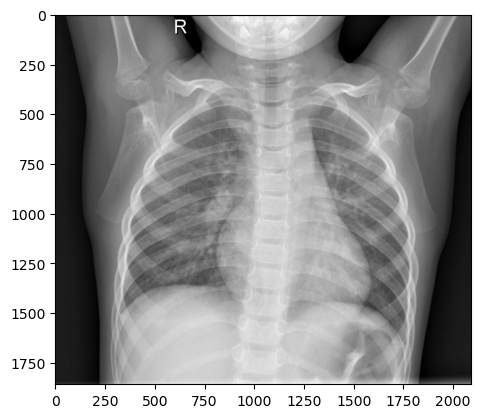

In [4]:
#Save the image as a variable name and then display it
sample_train_nml_img1 = cv2.imread(os.path.join(binary_train_dir,'NORMAL',train_normal_files[0]))
plt.imshow(sample_train_nml_img1)

In [7]:
#What is the shape of the image?
sample_train_nml_img1.shape

(1858, 2090, 3)

We see that the shape of this normal sample image has a height of 1858, width of 2090, and has 3 channels. The 3 channels are read in reverse by OpenCv as BGR (so it is normally RGB pre-read).

In [24]:
sample_train_nml_img1 = cv2.imread(os.path.join(binary_train_dir,'NORMAL',train_normal_files[0]))
#spliting the image into 3 channels to visualize
B, G, R = cv2.split(sample_train_nml_img1)

#Show original image and hold until closed
cv2.imshow('original',sample_train_nml_img1)
cv2.waitKey(0)
#Show blue channel and hold until closed
cv2.imshow('Blue',B)
cv2.waitKey(0)
#Show green channel and hold until closed
cv2.imshow('Green',G)
cv2.waitKey(0)
#Show red channel and hold until closed
cv2.imshow('Red',R)
cv2.waitKey(0)

#remove from memory
cv2.destroyAllWindows()

But they all look the same? This is because the BGR values are all the same for each channel. This makes black and white as the extreme values and everything between variations of gray. If they are different, the brighter they are the higher the value and contribution of that channel. Combination of channels fall under the combinations of light of Blue, Green, and Red. Blue and Green is Cyan; Blue and Red is Magenta; Green and Red is Yellow; All together is White; None of any is Black.

In [8]:
#Find out the min and max values of each of these pixels
print('Image minimum value: ',sample_train_nml_img1.min())
print('Image maximum value: ',sample_train_nml_img1.max())

Image minimum value:  0
Image maximum value:  255


When loading the image, we have a dtype of uint8 (unsigned), so the pixel intensity values range have 2^8 values or 256 values to work with. Because it is unsigned, it does not have negative values. The value starts at 0 meaning the pixel intensity values then range from 0-255. Note: later the range will be rescaled to be between 0-1 before applying it to a neural network for easier processing.

Next let's read in a pneumonia image.

In [9]:
#Reading an image from the train/NORMAL
cv2.imread(os.path.join(binary_train_dir,'PNEUMONIA',train_pna_files[0])) 

array([[[19, 19, 19],
        [19, 19, 19],
        [18, 18, 18],
        ...,
        [ 1,  1,  1],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[19, 19, 19],
        [19, 19, 19],
        [18, 18, 18],
        ...,
        [ 1,  1,  1],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[19, 19, 19],
        [19, 19, 19],
        [18, 18, 18],
        ...,
        [ 1,  1,  1],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       ...,

       [[10, 10, 10],
        [10, 10, 10],
        [10, 10, 10],
        ...,
        [15, 15, 15],
        [15, 15, 15],
        [15, 15, 15]],

       [[10, 10, 10],
        [10, 10, 10],
        [10, 10, 10],
        ...,
        [15, 15, 15],
        [15, 15, 15],
        [15, 15, 15]],

       [[10, 10, 10],
        [10, 10, 10],
        [10, 10, 10],
        ...,
        [15, 15, 15],
        [15, 15, 15],
        [15, 15, 15]]], dtype=uint8)

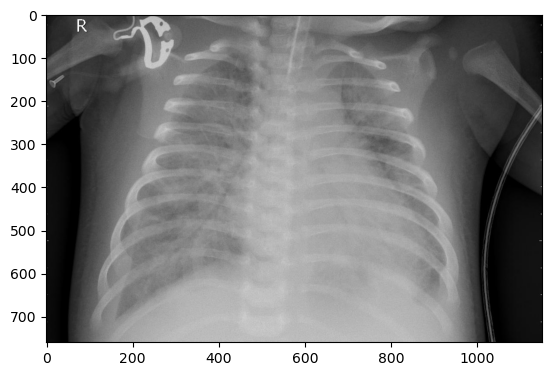

In [10]:
#Save the image as a variable name and then display it
sample_train_pna_img1 = cv2.imread(os.path.join(binary_train_dir,'PNEUMONIA',train_pna_files[0]))
plt.imshow(sample_train_pna_img1)

In [6]:
#What is the shape of the image?
sample_train_pna_img1.shape

(760, 1152, 3)

The image here has a much different size of 760 height and 1152 width. The image channels show the same 3 channels. 

In [11]:
#Find out the min and max values of each of these pixels
print('Image minimum value: ',sample_train_pna_img1.min())
print('Image maximum value: ',sample_train_pna_img1.max())

Image minimum value:  0
Image maximum value:  255


The values are the same range for pna image, again, because it has 8-bits per channel for 256 values and the first value being 0 making the highest 255.

We can notice two things:

- The image sizes between the normal and pneumonia are quite different. What would the distribution of image sizes be?

- The image of the pneumonia has equipment whereas the normal does not. I am concerned my model would not learn the image from the lungs but instead the equipment. 

Remember:

- We also have a class imbalance to rectify, the about 75:25 split between PNA:nml.

### Viewing the Image Height and Width Distributions

In [23]:
#Extract lengths of the train/normal and train/pneumonia images
train_normal_heights = [cv2.imread(os.path.join(binary_train_dir,'NORMAL',train_normal_files[x])).shape[0] for x in range(len(train_normal_files))]
train_normal_widths = [cv2.imread(os.path.join(binary_train_dir,'NORMAL',train_normal_files[x])).shape[1] for x in range(len(train_normal_files))]
train_pna_heights = [cv2.imread(os.path.join(binary_train_dir,'PNEUMONIA',train_pna_files[x])).shape[0] for x in range(len(train_pna_files))]
train_pna_widths = [cv2.imread(os.path.join(binary_train_dir,'PNEUMONIA',train_pna_files[x])).shape[1] for x in range(len(train_pna_files))]

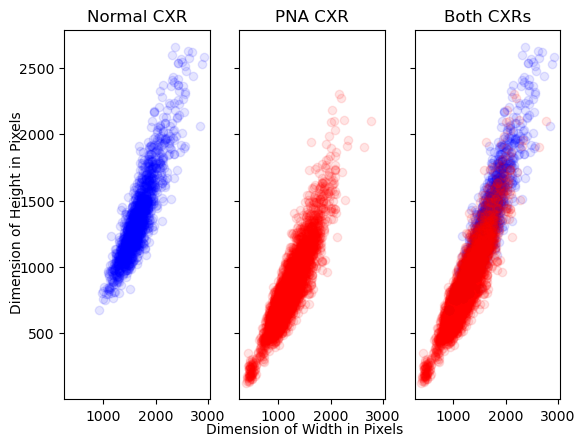

<Figure size 6000x2500 with 0 Axes>

In [24]:
#Ploting the height vs width of normal and pneumonia images
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,sharex=True, sharey=True)
plt.figure(figsize=(60,25))

ax1.scatter(train_normal_widths,train_normal_heights,c='blue',label='Normal',alpha=0.1)
ax1.set_title('Normal CXR')

ax2.scatter(train_pna_widths,train_pna_heights,c='red',label='Pneumonia',alpha=0.1)
ax2.set_title('PNA CXR')

ax3.scatter(train_normal_widths,train_normal_heights,c='blue',label='Normal',alpha=0.1)
ax3.scatter(train_pna_widths,train_pna_heights,c='red',label='Pneumonia',alpha=0.1)
ax3.set_title('Both CXRs')

fig.text(0.5,0.04,'Dimension of Width in Pixels',ha='center')
fig.text(0.04,0.5,'Dimension of Height in Pixels',va='center',rotation='vertical')

plt.tight_layout()
plt.show()

We see that the pneumonia images are generally smaller in size for both height and width compared to the normal images. Let's look closer into the descriptive statistics of these lengths.

In [25]:
#Create a dataframe for each image length
train_normal_heights_df = pd.DataFrame(train_normal_heights, columns=['normal_heights'])
train_normal_widths_df = pd.DataFrame(train_normal_widths, columns=['normal_widths'])
train_pna_heights_df = pd.DataFrame(train_pna_heights, columns=['pna_heights'])
train_pna_widths_df = pd.DataFrame(train_pna_widths, columns=['pna_widths'])

#Describe to get distribution
df1 = train_normal_heights_df.describe()
df2 = train_normal_widths_df.describe()
df3 = train_pna_heights_df.describe()
df4 = train_pna_widths_df.describe()

#Concatenate
train_image_lengths_describe = pd.concat([df1,df2,df3,df4],axis=1)
train_image_lengths_describe

normal_heights  normal_widths  pna_heights   pna_widths
count     1349.000000    1349.000000  3883.000000  3883.000000
mean      1380.306894    1666.618236   825.004121  1200.517641
std        325.929136     289.155073   276.902175   291.169690
min        672.000000     912.000000   127.000000   384.000000
25%       1152.000000    1466.000000   640.000000  1000.000000
50%       1325.000000    1638.000000   776.000000  1168.000000
75%       1541.000000    1820.000000   968.000000  1368.000000
max       2663.000000    2916.000000  2304.000000  2772.000000

Are the lengths normally distributed or not? Create a histogram for each.

In [26]:
#Importing to check if the distribution is normal, with the null hypothesis is from a normal distribution
from scipy.stats import shapiro

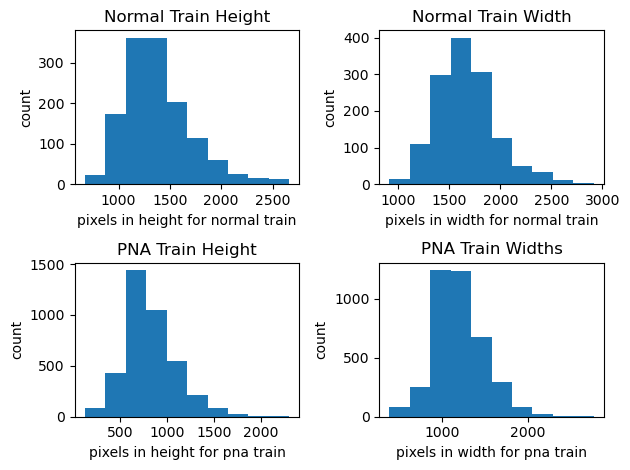

In [27]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2,ncols=2)
#normal height
ax1.hist(train_normal_heights)
ax1.set_xlabel('pixels in height for normal train')
ax1.set_ylabel('count')
ax1.set_title('Normal Train Height')
#normal width
ax2.hist(train_normal_widths)
ax2.set_xlabel('pixels in width for normal train')
ax2.set_ylabel('count')
ax2.set_title('Normal Train Width')
#pna height
ax3.hist(train_pna_heights)
ax3.set_xlabel('pixels in height for pna train')
ax3.set_ylabel('count')
ax3.set_title('PNA Train Height')
#pna width
ax4.hist(train_pna_widths)
ax4.set_xlabel('pixels in width for pna train')
ax4.set_ylabel('count')
ax4.set_title('PNA Train Widths')
plt.tight_layout()

In [28]:
#Conduct the shapiro test over each height and width distributions
print(shapiro(train_normal_heights))
print(shapiro(train_normal_widths))
print(shapiro(train_pna_heights))
print(shapiro(train_pna_widths))

ShapiroResult(statistic=0.9391380548477173, pvalue=4.372468564288988e-23)
ShapiroResult(statistic=0.9692157506942749, pvalue=2.384001758618014e-16)
ShapiroResult(statistic=0.9531880617141724, pvalue=1.449711468930203e-33)
ShapiroResult(statistic=0.9819640517234802, pvalue=7.545017592606358e-22)


The null hypothesis was that the distribution was normal. After conducting the Shapiro test, the p values resulting from it are below the 0.05 threshold, rejecting the null hypothesis and thus they are not normal. Because of this, I will reframe from using standard deviations as outliers and instead will use interquartile range (IQR) to find the upper and lower limits.

In [29]:
#IQR for identifying limits for errors
train_image_lengths_describe.loc['1.5_IQR'] = 1.5*(train_image_lengths_describe.loc['75%',:] - train_image_lengths_describe.loc['25%',:])
train_image_lengths_describe.loc['IQR_method_lower_bound'] = train_image_lengths_describe.loc['25%',:] - train_image_lengths_describe.loc['1.5_IQR',:]
train_image_lengths_describe.loc['IQR_method_upper_bound'] = train_image_lengths_describe.loc['75%',:] + train_image_lengths_describe.loc['1.5_IQR',:]

In [30]:
#Look into the changes of our datafrane
train_image_lengths_describe

normal_heights  normal_widths  pna_heights  \
count                      1349.000000    1349.000000  3883.000000   
mean                       1380.306894    1666.618236   825.004121   
std                         325.929136     289.155073   276.902175   
min                         672.000000     912.000000   127.000000   
25%                        1152.000000    1466.000000   640.000000   
50%                        1325.000000    1638.000000   776.000000   
75%                        1541.000000    1820.000000   968.000000   
max                        2663.000000    2916.000000  2304.000000   
1.5_IQR                     583.500000     531.000000   492.000000   
IQR_method_lower_bound      568.500000     935.000000   148.000000   
IQR_method_upper_bound     2124.500000    2351.000000  1460.000000   

                         pna_widths  
count                   3883.000000  
mean                    1200.517641  
std                      291.169690  
min                      384.000000  
25%                     1000.000000  
50%                     1168.000000  
75%                     1368.000000  
max                     2772.000000  
1.5_IQR                  552.000000  
IQR_method_lower_bound   448.000000  
IQR_method_upper_bound  1920.000000

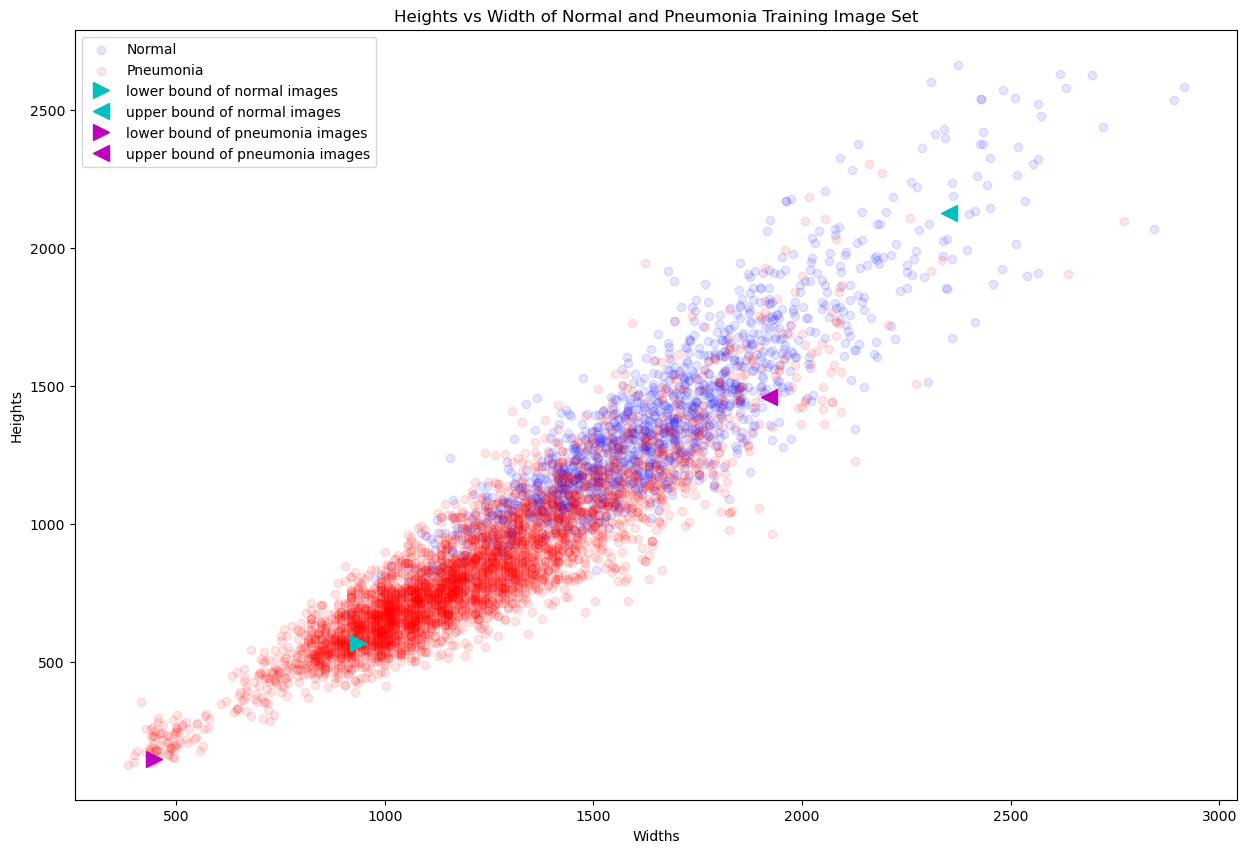

In [31]:
#Ploting the height vs width of normal and pneumonia images
plt.figure(figsize=(15,10))
plt.scatter(train_normal_widths,train_normal_heights,c='blue',label='Normal',alpha=0.1)
plt.scatter(train_pna_widths,train_pna_heights,c='red',label='Pneumonia',alpha=0.1)

plt.plot(train_image_lengths_describe.loc['IQR_method_lower_bound','normal_widths'],
         train_image_lengths_describe.loc['IQR_method_lower_bound','normal_heights'],
         'c>', markersize=12, label='lower bound of normal images')
         
plt.plot(train_image_lengths_describe.loc['IQR_method_upper_bound','normal_widths'],
         train_image_lengths_describe.loc['IQR_method_upper_bound','normal_heights'],
         'c<', markersize=12, label='upper bound of normal images')

plt.plot(train_image_lengths_describe.loc['IQR_method_lower_bound','pna_widths'],
         train_image_lengths_describe.loc['IQR_method_lower_bound','pna_heights'],
         'm>', markersize=12, label='lower bound of pneumonia images')
         
plt.plot(train_image_lengths_describe.loc['IQR_method_upper_bound','pna_widths'],
         train_image_lengths_describe.loc['IQR_method_upper_bound','pna_heights'],
         'm<', markersize=12, label='upper bound of pneumonia images')
         
plt.legend()
plt.xlabel('Widths')
plt.ylabel('Heights')
plt.title('Heights vs Width of Normal and Pneumonia Training Image Set')
plt.show()

The cyan arrows surround the error free range of the blue circles, normal images. Error free being within 1.5 IQR from the Q1 and Q3. In constrast, the magenta arrows surround the error free range of red circles, pna images. Therefore, an intersection between these ranges would be error free for both within the right of the cyan, the lower bound, and to the left of the magenta, the upper bound. 

We have proved that normal images are larger compared to those with pneumonia. Despite this, we will have to scale down the image size at the lower thresholds of lengths anyway in order to fit image processing models like a vanilla CNN, ResNet-50, or U-Net. This can be done by setting the target size when the images are batched later.

### Focusing on the Lungs over Equipment

Before we set the target size of normal and pneumonia chest x-rays, we will reduce them by focusing the image on the lungs. This will remove more equipment for that to have less of an impact on the prediction of the image than before.

In [ ]:
#Reset the directory to be where this notebook is
#Rerun if an image is saved requiring it to change directory
os.chdir('C:/Users/Ken/Documents/Python Scripts/')

In [ ]:
#Reestablish directory paths
binary_dir = './data/pna_cxr_data/chest_xray/binary/'
binary_train_dir = './data/pna_cxr_data/chest_xray/binary/train/'
binary_val_dir = './data/pna_cxr_data/chest_xray/binary/val/'
binary_test_dir = './data/pna_cxr_data/chest_xray/binary/test/'

Using Opencv, let's look at this image in a separate window and see the equipment.

In [27]:
#Opening an image and remain open until closed
sample_train_pna_img1 = cv2.imread(os.path.join(binary_train_dir,'PNEUMONIA',train_pna_files[0]))
cv2.imshow('train_pna_img1',sample_train_pna_img1)
cv2.waitKey(0)  
cv2.destroyAllWindows()

After changing the loaded image into grayscale, we will apply Otsu's thresholding which is a technique to auto-select a threshold to best distinguish between clusters of intensity values to begin separation of the lungs. 

A binary mask is created to make the lungs white and the background black to isolate it while eliminating noise. 

We will find parts of the image that are connected along with its statistics to select the largest part, the lungs, as the mask to define the region. 

This will crop the original image accordingly and will output two pictures: the original and the newly cropped that focuses on the lungs.

In [35]:
#Load image and turn to grayscale
img = cv2.imread(os.path.join(binary_train_dir,'PNEUMONIA',train_pna_files[0]))
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Apply Otsu's thresholding
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Apply morphological operations to smooth the binary mask
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
morphed = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

# Perform connected component analysis to find the largest connected component
_, labels, stats, centroids = cv2.connectedComponentsWithStats(morphed)
largest_label = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1
mask = np.uint8(labels == largest_label)

# Find the bounding box of the largest connected component
x, y, w, h = cv2.boundingRect(mask)

# Crop the original image using the bounding box
cropped = img[y:y+h, x:x+w]

# Display the original image and the cropped image
cv2.imshow('Original', img)
cv2.imshow('Cropped', cropped)
cv2.waitKey(0)
cv2.destroyAllWindows()

We see that we removed the majority of the equipment as well as reducing the size of the image, so we increase the signal and reduce the noise of what we want to analyze in the future. Let's apply this to all images and save them as a function.

In [19]:
def focus_on_lungs(inPath):    
    for imagePath in os.listdir(inPath):
        #Load image and turn to grayscale
        img = cv2.imread(os.path.join(inPath,imagePath))
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Apply Otsu's thresholding
        _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Apply morphological operations to smooth the binary mask
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        morphed = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

        # Perform connected component analysis to find the largest connected component
        _, labels, stats, centroids = cv2.connectedComponentsWithStats(morphed)
        largest_label = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1
        mask = np.uint8(labels == largest_label)

        # Find the bounding box of the largest connected component
        x, y, w, h = cv2.boundingRect(mask)

        # Crop the original image using the bounding box
        img_cropped = img[y:y+h, x:x+w]

        # Save the image
        saved_file_name = os.path.join(inPath,imagePath)
        cv2.imwrite(saved_file_name,img_cropped)

In [36]:
#Crop the images to focus on the lungs for train
focus_on_lungs('C:/Users/Ken/Documents/Python Scripts/data/pna_cxr_data/chest_xray/binary/train/NORMAL/')
focus_on_lungs('C:/Users/Ken/Documents/Python Scripts/data/pna_cxr_data/chest_xray/binary/train/PNEUMONIA/')

The validation is empty because it was moved to train, and the test should not be altered.

In [38]:
#Check the new normal file number
train_normal_files = os.listdir(os.path.join(binary_train_dir,'NORMAL'))
print('train/NORMAL size: ',len(train_normal_files))

#Check the new pna file number
train_pna_files = os.listdir(os.path.join(binary_train_dir,'PNEUMONIA'))
print('train/PNEUMONIA size: ',len(train_pna_files))

train/NORMAL size:  1349
train/PNEUMONIA size:  3883


This is a one-to-one conversion. Let's take a look at the prior two images shown to see how they look now.

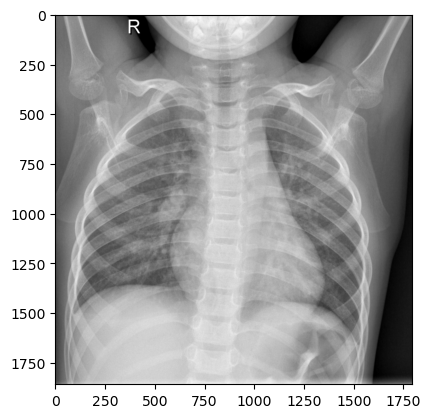

In [41]:
#Save the image as a variable name and then display it
sample_train_nml_img1 = cv2.imread(os.path.join(binary_train_dir,'NORMAL',train_normal_files[0]))
plt.imshow(sample_train_nml_img1)

The prior shape had a height of 1858, width of 2090, and 3 channels. 

In [43]:
sample_train_nml_img1.shape

(1858, 1793, 3)

Now the image shrank, and particularly by the width.

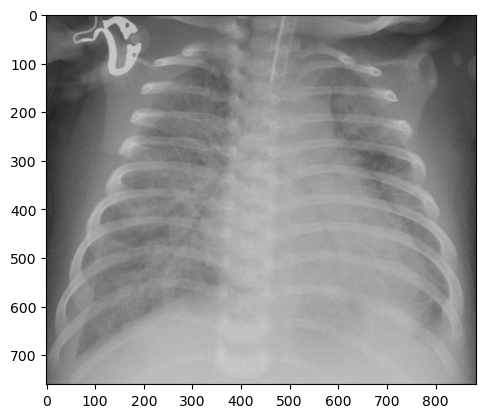

In [42]:
#Save the image as a variable name and then display it
sample_train_pna_img1 = cv2.imread(os.path.join(binary_train_dir,'PNEUMONIA',train_pna_files[0]))
plt.imshow(sample_train_pna_img1)

Before the image had a height of 760, width of 1152, and 3 channels.

In [44]:
sample_train_pna_img1.shape

(760, 883, 3)

This also had its width decreased with less equipment shown.

### Creating Image Datagenerators

We will create image datagenerators to add more versions of the images, i.e., image augmentation, to make the classifier more robust by increasing the amount of data seen. This is another way of dealing with class imbalance instead of upsampling or downsampling to be more generalized and not overfit. The methods of flipping, rotating, and zooming were choosen because they were non-destructive/do not distort the image. They will batch the images to be fed into different image classifiers.

In [14]:
#Setting parameters for flow_from_directory
pixels = 224 #The height and width will be set as the same, notice this will push the images to the same size.
batch_size = 32 #Each batch will have 32 images
class_mode = 'binary' #This is binary so it will be set as such
color_mode = 'rgb' #This will give a 3 channel input
seed = 42 #This is for consistency between models

In [15]:
#Instantiating train and validation
#Flipping, rotating, and zooming allow for more variation
datagen_train = ImageDataGenerator(rescale = 1./255, #This is will convert the 0-255 to have values between 0 and 1 
                                  horizontal_flip=True, 
                                  vertical_flip=True,
                                  rotation_range=15,
                                  zoom_range=0.2,
                                  fill_mode='reflect', #When augmenting, there will be space that needs to be filled. This specifies how.
                                  validation_split=0.1) #The val will be given 10% which is approx the size of the test

#Normalizing the validation
validation_generator = ImageDataGenerator(rescale=1./255) #This is done the same so that when validating it will be in the same scale from 0 to 1

#The data will flow from the train directory that is separated between the 'training' and 'validation' subsets
#Most of the flow from directory 
#Generator for training data, shuffle set to True
train_generator = datagen_train.flow_from_directory(binary_train_dir,
                                                   target_size=(pixels, pixels),
                                                   color_mode= color_mode,
                                                   batch_size=batch_size,
                                                   class_mode= class_mode,
                                                   shuffle=True, subset='training', #shuffled to reduce overfitting
                                                   seed = seed)

#Generator for validation data, shuffle set to False
validation_generator = datagen_train.flow_from_directory(binary_train_dir,
                                                        target_size=(pixels, pixels),
                                                        color_mode=color_mode,
                                                        batch_size=batch_size,
                                                        class_mode=class_mode,
                                                        shuffle=False, subset='validation', #shuffling will not change anything in the validation since no training is done
                                                        seed = seed)

Found 4710 images belonging to 2 classes.
Found 522 images belonging to 2 classes.


In [16]:
#Normalizing the Test
datagen_test = ImageDataGenerator(rescale=1./255) #This is done the same so that the test will be in the same scale from 0 to 1

#Generator for test data
test_generator = datagen_test.flow_from_directory(binary_test_dir,
                                                   target_size=(pixels, pixels),
                                                   color_mode=color_mode,
                                                   batch_size=624, #Batch size should be the entire set
                                                   class_mode= class_mode,
                                                   seed = seed)
X_test,y_test =test_generator.next()

Found 624 images belonging to 2 classes.


In [18]:
train_step = train_generator.samples/train_generator.batch_size
print('# of steps for Train: ',round(train_step))
val_step = validation_generator.samples/validation_generator.batch_size
print('# of steps for Validation: ',round(val_step))

# of steps for Train:  147
# of steps for Validation:  16


Let's visualize the training's first batch.

In [19]:
batch = train_generator.next()

In [52]:
len(batch) #Images and labels

2

In [54]:
#These are the images
batch[0].shape

(32, 224, 224, 3)

There are 32 images in this batch that are 224x224 and has 3 channels because it uses rgb.

In [55]:
#First image of batch example
batch[0][0]

array([[[0.25962743, 0.25962743, 0.25962743],
        [0.22576775, 0.22576775, 0.22576775],
        [0.19073209, 0.19073209, 0.19073209],
        ...,
        [0.34098104, 0.34098104, 0.34098104],
        [0.315314  , 0.315314  , 0.315314  ],
        [0.27764073, 0.27764073, 0.27764073]],

       [[0.24594007, 0.24594007, 0.24594007],
        [0.24153124, 0.24153124, 0.24153124],
        [0.21109349, 0.21109349, 0.21109349],
        ...,
        [0.31650874, 0.31650874, 0.31650874],
        [0.32303923, 0.32303923, 0.32303923],
        [0.2747194 , 0.2747194 , 0.2747194 ]],

       [[0.20743352, 0.20743352, 0.20743352],
        [0.23865318, 0.23865318, 0.23865318],
        [0.21249767, 0.21249767, 0.21249767],
        ...,
        [0.31889987, 0.31889987, 0.31889987],
        [0.30735868, 0.30735868, 0.30735868],
        [0.2894298 , 0.2894298 , 0.2894298 ]],

       ...,

       [[0.3663238 , 0.3663238 , 0.3663238 ],
        [0.59111154, 0.59111154, 0.59111154],
        [0.57374   , 0

In [56]:
#These are the labels as normal or pneumonia
batch[1].shape

(32,)

In [57]:
#These are the labels
batch[1]

array([0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0.,
       0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.],
      dtype=float32)

The values are 0 or 1 for either of the two classes.

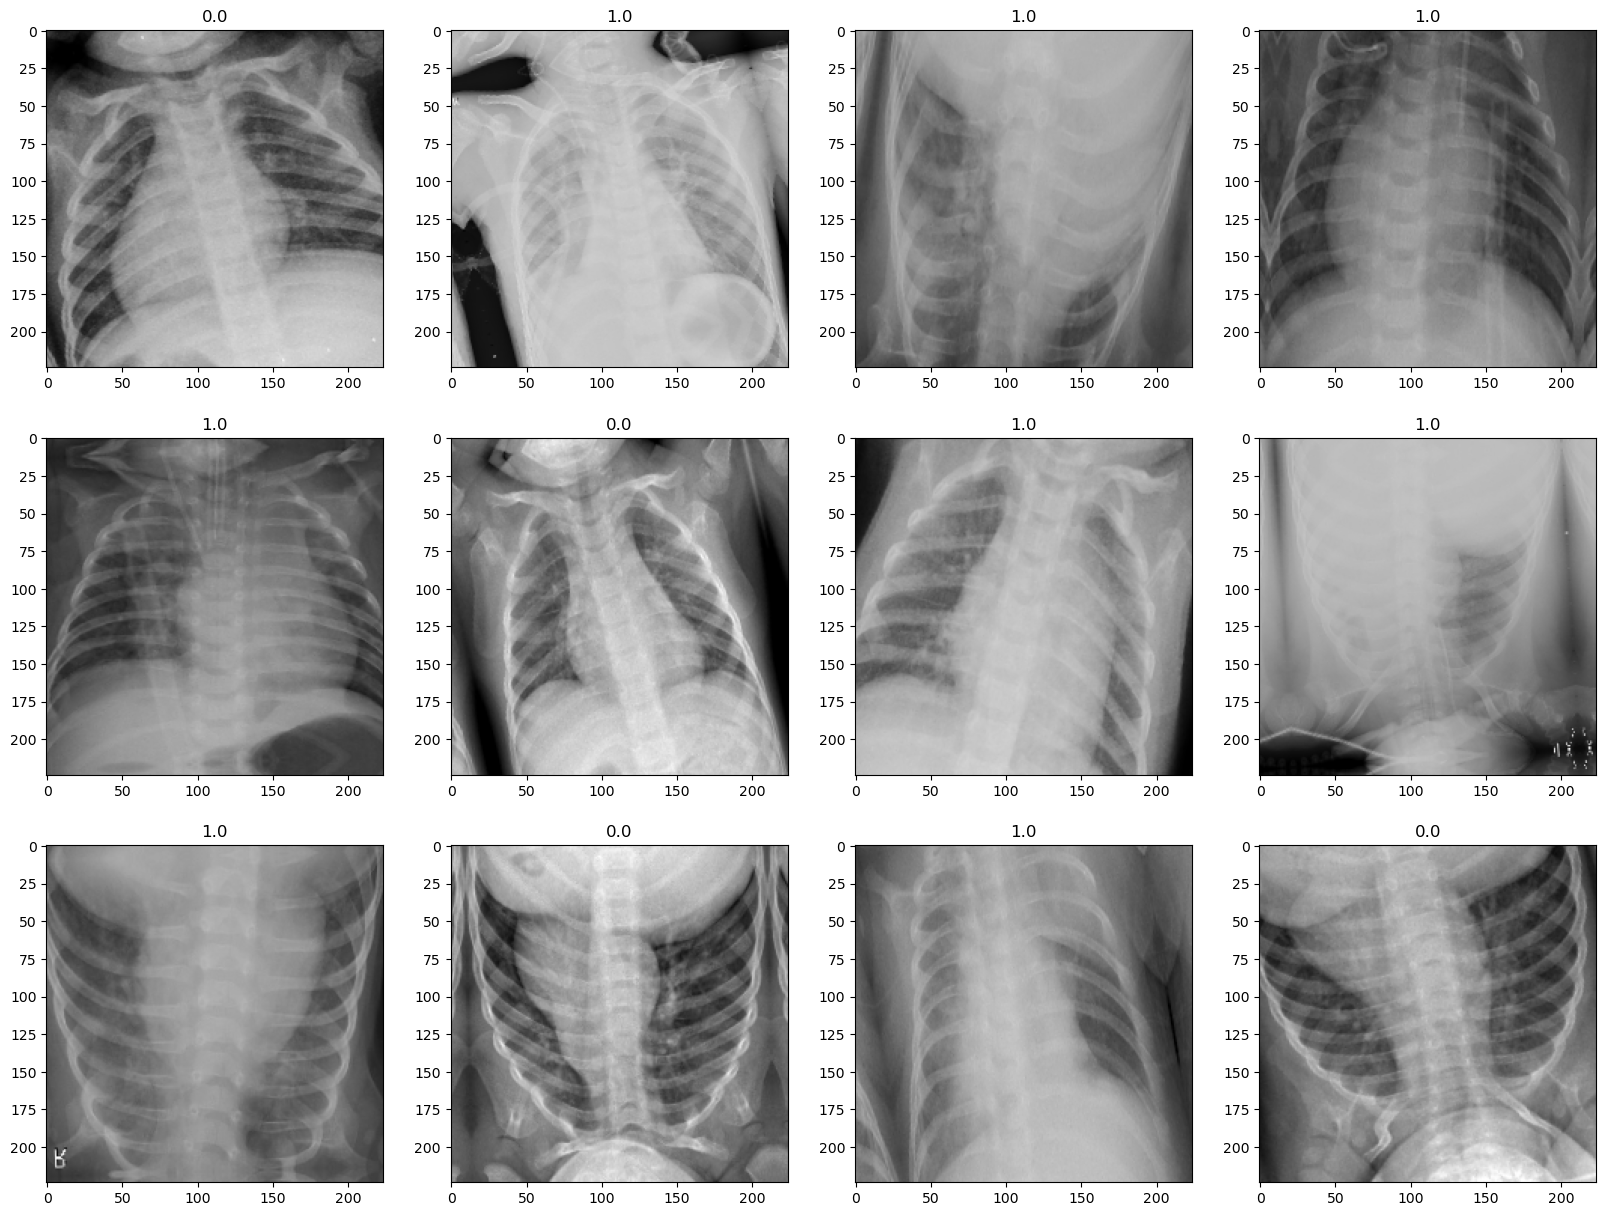

In [58]:
#Plot out 12 images with 3 rows and 4 columns
fig, ax = plt.subplots(nrows=3,ncols=4,figsize=(20,15))
#Turn it into 1D
ax = ax.flatten()
for idx, img in enumerate(batch[0][:12]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

Here we can see that the images have been augmented by being flipped, zoomed, or rotated.

## Binary Models

With this project, I will be creating 3 binary models: 

(1) CNN model

(2) a ResNet-50 model with transfer learning with early stop

(3) a ResNet-50 model with transfer learning without early stop

For the models, there can be two ways for a physician to use it:

1. If the model predicts above a certain percentage like 97% that it is either normal or pneumonia, then the physician would not have to review that image. In this case, accuracy would be an important measure.


2. As long as the model will not misclassify a pneumonia image as normal, all the pneumonia cases can be reviewed by the physician. Why? It would be more detrimental to have a false negative, declaring a pneumonia as normal than a false positive (the other way around). This means all the normal images will not have to be reviewed. For the evaluation metric, we can focus on recall since we want to be able to catch all the pneumonia cases. 

Other metric to evaluate can be AUC for the overall model's predictive power.

Note that specific model results will be recorded with wandb (weights and biases).

### Binary CNN Model

#### Building the Binary CNN Model

In [20]:
#create a model, initialized here
model = Sequential()
#first layer needs to have an input, see input_shape. 
#convolution here has 16 filters to extract relevant info
#a kernel for convolution is 3x3 pixels in size with a stride of 1.
#relu makes all negative = 0, and positive values are directly proportional
model.add(Conv2D(16,(3,3),1,activation='relu',input_shape=(224,224,3))) 

#Takes the max value of a set region to condense information, 
#by default this region size is 2x2, i.e. pool_size. 1/2 of width and height.
model.add(MaxPooling2D())

model.add(Conv2D(32,(3,3),1,activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16,(3,3),1,activation='relu'))
model.add(MaxPooling2D())

#Prepares the model to transition to the dense neural network
model.add(Flatten())

model.add(Dense(224,activation='relu'))

#We have 1 as the output
model.add(Dense(1,activation='sigmoid'))

In [21]:
#Because the class is imbalanced, partial to the pneumonia class, 
    #we can weight the values as an additional measure.    
    #For every instance of pneumonia class, count normal class as 3 instances
    #This is because we have a 25:75 split for normal to pneumonia.

class_weight = {} 
unique, counts = np.unique(batch[1],return_counts=True)
for i in range(len(unique)):
    class_weight[unique[i]] = counts.max()/counts[i]

In [22]:
class_weight

{0.0: 2.2, 1.0: 1.0}

In [23]:
#The optimizer is adam, loss is binarycrossentropy for binaryclassifier 
#Metrics are Accuracy AUC and Recall 
    #to understand the model as a whole and to measure the number of false negatives 
    #the number of pneumonia labeled as normal 
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(),
              metrics=['accuracy','AUC','Recall'])

In [24]:
#shows what happens at each step
model.summary() 
#before going to flatten layer 26*26*16 ->10816 for 1dim from many
#225 is the weight of the 224 neurons + 1 for the bias term

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 26, 26, 16)      

#### Training the Binary CNN Model

In [25]:
#Set the number of epochs
epochs = 10

In [26]:
#Initalize a new run (with weights and biases specifying a team name) and returns a run object,
#It creates a local directory where all logs and files are saved
#Pass in config={:,:,:} for what will be the hyperparameters,dataset name, model type,ind var to compare different runs 
wandb.init(project="Binary-CNN", entity="team-lkc",
          config={
              "epochs":epochs,
              "batch size":batch_size,
              "class mode":class_mode,
              "height and width in pixels":pixels,
              "number of channels":color_mode,
              "class weight":class_weight,
              "seed":seed
          })

wandb: Currently logged in as: lkc562 (team-lkc). Use `wandb login --relogin` to force relogin


In [27]:
#an epoch is 1 run over entire training set of data
hist = model.fit(train_generator,
                 epochs=epochs,
                 validation_data=validation_generator,
                 class_weight=class_weight, #class_weight needs to be added here not the compile
                 callbacks=[WandbCallback()])

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/10
148/148 [==============================] - ETA: 0s - loss: 0.6607 - accuracy: 0.7639 - auc: 0.8155 - recall: 0.8186

INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230318_124715-lnnyjs70\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230318_124715-lnnyjs70\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Ken\Documents\Python Scripts\wandb\run-20230318_124715-lnnyjs70\files\model-best)... Done. 0.1s


148/148 [==============================] - 139s 929ms/step - loss: 0.6607 - accuracy: 0.7639 - auc: 0.8155 - recall: 0.8186 - val_loss: 0.4032 - val_accuracy: 0.8180 - val_auc: 0.9346 - val_recall: 0.7809
Epoch 2/10
148/148 [==============================] - ETA: 0s - loss: 0.4262 - accuracy: 0.8633 - auc: 0.9338 - recall: 0.8684

INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230318_124715-lnnyjs70\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230318_124715-lnnyjs70\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Ken\Documents\Python Scripts\wandb\run-20230318_124715-lnnyjs70\files\model-best)... Done. 0.1s


148/148 [==============================] - 132s 887ms/step - loss: 0.4262 - accuracy: 0.8633 - auc: 0.9338 - recall: 0.8684 - val_loss: 0.2998 - val_accuracy: 0.8716 - val_auc: 0.9322 - val_recall: 0.8969
Epoch 3/10
148/148 [==============================] - 130s 879ms/step - loss: 0.3585 - accuracy: 0.8902 - auc: 0.9531 - recall: 0.8930 - val_loss: 0.3161 - val_accuracy: 0.8640 - val_auc: 0.9328 - val_recall: 0.8866
Epoch 4/10
148/148 [==============================] - ETA: 0s - loss: 0.3487 - accuracy: 0.8966 - auc: 0.9561 - recall: 0.9030

INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230318_124715-lnnyjs70\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230318_124715-lnnyjs70\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Ken\Documents\Python Scripts\wandb\run-20230318_124715-lnnyjs70\files\model-best)... Done. 0.1s


148/148 [==============================] - 137s 923ms/step - loss: 0.3487 - accuracy: 0.8966 - auc: 0.9561 - recall: 0.9030 - val_loss: 0.2763 - val_accuracy: 0.8870 - val_auc: 0.9462 - val_recall: 0.9201
Epoch 5/10
148/148 [==============================] - ETA: 0s - loss: 0.3173 - accuracy: 0.9072 - auc: 0.9632 - recall: 0.9119

INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230318_124715-lnnyjs70\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230318_124715-lnnyjs70\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Ken\Documents\Python Scripts\wandb\run-20230318_124715-lnnyjs70\files\model-best)... Done. 0.1s


148/148 [==============================] - 132s 892ms/step - loss: 0.3173 - accuracy: 0.9072 - auc: 0.9632 - recall: 0.9119 - val_loss: 0.2628 - val_accuracy: 0.9004 - val_auc: 0.9699 - val_recall: 0.8737
Epoch 6/10
148/148 [==============================] - ETA: 0s - loss: 0.3053 - accuracy: 0.9070 - auc: 0.9660 - recall: 0.9107

INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230318_124715-lnnyjs70\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230318_124715-lnnyjs70\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Ken\Documents\Python Scripts\wandb\run-20230318_124715-lnnyjs70\files\model-best)... Done. 0.1s


148/148 [==============================] - 131s 883ms/step - loss: 0.3053 - accuracy: 0.9070 - auc: 0.9660 - recall: 0.9107 - val_loss: 0.2598 - val_accuracy: 0.8985 - val_auc: 0.9591 - val_recall: 0.9124
Epoch 7/10
148/148 [==============================] - ETA: 0s - loss: 0.3052 - accuracy: 0.9062 - auc: 0.9660 - recall: 0.9090

INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230318_124715-lnnyjs70\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230318_124715-lnnyjs70\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Ken\Documents\Python Scripts\wandb\run-20230318_124715-lnnyjs70\files\model-best)... Done. 0.1s


148/148 [==============================] - 138s 934ms/step - loss: 0.3052 - accuracy: 0.9062 - auc: 0.9660 - recall: 0.9090 - val_loss: 0.2190 - val_accuracy: 0.8985 - val_auc: 0.9685 - val_recall: 0.8969
Epoch 8/10
148/148 [==============================] - 131s 884ms/step - loss: 0.2910 - accuracy: 0.9153 - auc: 0.9690 - recall: 0.9187 - val_loss: 0.2682 - val_accuracy: 0.8966 - val_auc: 0.9576 - val_recall: 0.8866
Epoch 9/10
148/148 [==============================] - 130s 878ms/step - loss: 0.2748 - accuracy: 0.9155 - auc: 0.9725 - recall: 0.9176 - val_loss: 0.2639 - val_accuracy: 0.9061 - val_auc: 0.9667 - val_recall: 0.8892
Epoch 10/10
148/148 [==============================] - 130s 877ms/step - loss: 0.2571 - accuracy: 0.9244 - auc: 0.9755 - recall: 0.9270 - val_loss: 0.2969 - val_accuracy: 0.8985 - val_auc: 0.9620 - val_recall: 0.8969


#### Evaluating Binary CNN Model

In [28]:
score = model.evaluate(X_test,y_test,verbose=1)
wandb.log({'Test Loss': score[0], 'Test Accuracy': score[1]})

20/20 [==============================] - 1s 62ms/step - loss: 0.3228 - accuracy: 0.8910 - auc: 0.9400 - recall: 0.9333


Recall that the baseline for this imbalanced set is 75% accuracy based on the majority class of pneumonia.

In [53]:
#Setting threshold to get as much recall
threshold = 0.002

In [54]:
predict_probas = model.predict(X_test)
y_predict = np.where(predict_probas>threshold,1,0)

20/20 [==============================] - 1s 58ms/step


In [55]:
conf_mat = confusion_matrix(y_test,y_predict)
cf_df = pd.DataFrame(conf_mat,columns=["Predicted Normal","Predicted Pneumonia"],index=["True Normal","True Pneumonia"])
cf_df

Predicted Normal  Predicted Pneumonia
True Normal                    8                  226
True Pneumonia                 0                  390

Ideally we want no false negatives, so no True Pneumonia predicted as Normal.

In [56]:
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

         0.0       1.00      0.03      0.07       234
         1.0       0.63      1.00      0.78       390

    accuracy                           0.64       624
   macro avg       0.82      0.52      0.42       624
weighted avg       0.77      0.64      0.51       624



Ideally we want a recall of 1.0 as 1.00

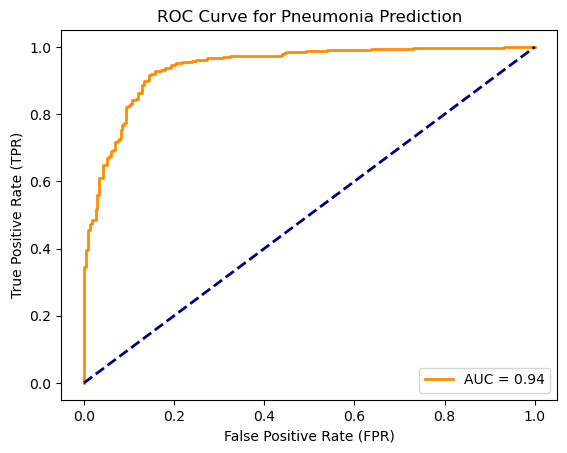

Area under curve (AUC):0.9411790488713566


In [57]:
fprs, tprs, thresholds = roc_curve(y_test, predict_probas)
roc_auc = roc_auc_score(y_test, predict_probas)

plt.figure()
plt.plot(fprs, tprs, color='darkorange',
         lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Pneumonia Prediction')
plt.legend(loc="best")
plt.show()

print(f'Area under curve (AUC):{roc_auc}')

This model is not that great despite having a high AUC of 0.94. The test accuracy was 0.8910 with a test loss of 0.3228. The recall was 0.9333, but in order to get the 100% recall the threshold had to be set to 0.002 which is too low to be practical. With only 8 images being predicted as normal that is truly normal, this would hardly alleviate a physician's workload.

Recap of problems and approaches:

- **There was a height and width difference between normal and pneumonia images.** 

This was dealt with by using image datagenerator object's flow_from_directory's parameter target_size. This allow the images to be set the same regardless of class.

- **There was apparent equipment shown in pneumonia images over normal images.** 

This was mediated by cropping using opencv and focusing on the lungs to reduce the image size. This removed some equipment to improve the signal over noise, and also reduced the processing for the modeling in the future.

- **There was a class imbalance between normal and pneumonia images.** 

Instead of upsampling the minority class or downsampling the majority class, we used the image datagenerators to create more image variation to not overfit the model. In addition, we applied class weights when fitting the model to have more emphasis on the smaller training class, normal than the pneumonia class.

### Binary ResNet-50 Transfer Learning with Early Stop

#### Building the Binary ResNet-50 - TL 

In [58]:
def set_random_seed(seed):    
    '''Random seeds for reproducability'''
    random.seed(seed)
    tf.random.set_seed(seed)

In [59]:
#pixels -> 224
#Any images larger than 224x224 need to be reshaped to 224 in train and validation
res_model = ResNet50V2(weights='imagenet', #ImageNet was how the initial layers were trained
                      include_top=False, #We are applying transfer learning so remove
                      input_shape=(224,224,3)) #Applying a grayscale image

In [60]:
#Freeze all layers in the base model
for layer in res_model.layers:
    layer.trainable = False

In [61]:
seed = 42
set_random_seed(seed)
x = res_model.output

x = Flatten()(x)
x = Dense(32, activation='relu')(x)

#one of the two classes
output = Dense(1,activation='sigmoid')(x)

trsf_model = Model(inputs=res_model.input,
                   outputs=output)

In [62]:
trsf_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy','AUC','Recall']
                  )

In [63]:
trsf_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_preact_relu (Acti  (None, 56, 56, 256)  0          ['conv2_block3_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 56, 56, 64)   16384       ['conv2_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_blo

 conv3_block2_2_conv (Conv2D)   (None, 28, 28, 128)  147456      ['conv3_block2_2_pad[0][0]']     
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block1_1_conv (Conv2D)   (None, 14, 14, 256)  131072      ['conv4_block1_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_2_pad (ZeroPaddin  (None, 16, 16, 256)  0          ['conv4_block1_1_relu[0][0]']    
 g2D)     

                                                                                                  
 conv4_block3_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block3_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block3_out (Add)         (None, 14, 14, 1024  0           ['conv4_block2_out[0][0]',       
                                )                                 'conv4_block3_3_conv[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block6_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block6_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block6_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block6_2_pad (ZeroPaddin  (None, 16, 16, 256)  0          ['conv4_block6_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv4_block6_2_conv (Conv2D)   (None, 7, 7, 256)    589824      ['conv4_block6_2_pad[0][0]']     
          

                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_out (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_conv[0][0]']    
                                                                                                  
 conv5_block3_preact_bn (BatchN  (None, 7, 7, 2048)  8192        ['conv5_block2_out[0][0]']       
 ormalization)                                                                                    
                                                                                                  
 conv5_block3_preact_relu (Acti  (None, 7, 7, 2048)  0           ['conv5_block3_preact_bn[0][0]'] 
 vation)  

#### Training the Binary ResNet-50 - TL + Early Stop

In [64]:
#early stop when no longer improving on validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=2, #wait for 2 epochs to stop if no improvement
                           mode='min',
                           verbose=1)

In [65]:
epochs = 10
early_stop_binary = True

In [66]:
wandb.init(project="Binary-ResNet50-TL-EarlyStop", entity="team-lkc",
          config={
              "epochs":epochs,
              "batch size":batch_size,
              "class mode":class_mode,
              "height and width in pixels":pixels,
              "number of channels":color_mode,
              "early stop implemented":early_stop_binary,
              "seed":seed
          })

In [67]:
#No weights here because the weights were pretrained with the transfer learning
hist = trsf_model.fit(train_generator,
                     epochs=epochs,
                     validation_data=validation_generator,
                     callbacks=[WandbCallback(),early_stop]) #early_stop in the callback will stop training if needed

Epoch 1/10
148/148 [==============================] - ETA: 0s - loss: 0.3417 - accuracy: 0.9144 - auc: 0.9492 - recall: 0.9431

INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230318_131844-ad7osi38\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230318_131844-ad7osi38\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Ken\Documents\Python Scripts\wandb\run-20230318_131844-ad7osi38\files\model-best)... Done. 0.3s


148/148 [==============================] - 237s 2s/step - loss: 0.3417 - accuracy: 0.9144 - auc: 0.9492 - recall: 0.9431 - val_loss: 0.2363 - val_accuracy: 0.9253 - val_auc: 0.9748 - val_recall: 0.9510
Epoch 2/10
148/148 [==============================] - ETA: 0s - loss: 0.1827 - accuracy: 0.9395 - auc: 0.9746 - recall: 0.9619

INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230318_131844-ad7osi38\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230318_131844-ad7osi38\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Ken\Documents\Python Scripts\wandb\run-20230318_131844-ad7osi38\files\model-best)... Done. 0.3s


148/148 [==============================] - 232s 2s/step - loss: 0.1827 - accuracy: 0.9395 - auc: 0.9746 - recall: 0.9619 - val_loss: 0.1829 - val_accuracy: 0.9387 - val_auc: 0.9833 - val_recall: 0.9459
Epoch 3/10
148/148 [==============================] - ETA: 0s - loss: 0.1270 - accuracy: 0.9546 - auc: 0.9874 - recall: 0.9740

INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230318_131844-ad7osi38\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230318_131844-ad7osi38\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Ken\Documents\Python Scripts\wandb\run-20230318_131844-ad7osi38\files\model-best)... Done. 0.3s


148/148 [==============================] - 237s 2s/step - loss: 0.1270 - accuracy: 0.9546 - auc: 0.9874 - recall: 0.9740 - val_loss: 0.1415 - val_accuracy: 0.9406 - val_auc: 0.9858 - val_recall: 0.9485
Epoch 4/10
148/148 [==============================] - 236s 2s/step - loss: 0.1202 - accuracy: 0.9609 - auc: 0.9878 - recall: 0.9751 - val_loss: 0.1951 - val_accuracy: 0.9330 - val_auc: 0.9842 - val_recall: 0.9227
Epoch 5/10
148/148 [==============================] - ETA: 0s - loss: 0.1133 - accuracy: 0.9582 - auc: 0.9886 - recall: 0.9725

INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230318_131844-ad7osi38\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230318_131844-ad7osi38\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Ken\Documents\Python Scripts\wandb\run-20230318_131844-ad7osi38\files\model-best)... Done. 0.3s


148/148 [==============================] - 226s 2s/step - loss: 0.1133 - accuracy: 0.9582 - auc: 0.9886 - recall: 0.9725 - val_loss: 0.1223 - val_accuracy: 0.9598 - val_auc: 0.9925 - val_recall: 0.9588
Epoch 6/10
148/148 [==============================] - 215s 1s/step - loss: 0.1072 - accuracy: 0.9607 - auc: 0.9901 - recall: 0.9737 - val_loss: 0.1272 - val_accuracy: 0.9579 - val_auc: 0.9852 - val_recall: 0.9768
Epoch 7/10
148/148 [==============================] - ETA: 0s - loss: 0.1046 - accuracy: 0.9631 - auc: 0.9897 - recall: 0.9734

INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230318_131844-ad7osi38\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230318_131844-ad7osi38\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Ken\Documents\Python Scripts\wandb\run-20230318_131844-ad7osi38\files\model-best)... Done. 0.2s


148/148 [==============================] - 229s 2s/step - loss: 0.1046 - accuracy: 0.9631 - auc: 0.9897 - recall: 0.9734 - val_loss: 0.1095 - val_accuracy: 0.9636 - val_auc: 0.9880 - val_recall: 0.9820
Epoch 8/10
148/148 [==============================] - 218s 1s/step - loss: 0.1048 - accuracy: 0.9592 - auc: 0.9895 - recall: 0.9725 - val_loss: 0.1285 - val_accuracy: 0.9483 - val_auc: 0.9883 - val_recall: 0.9485
Epoch 9/10
148/148 [==============================] - 212s 1s/step - loss: 0.0818 - accuracy: 0.9722 - auc: 0.9935 - recall: 0.9797 - val_loss: 0.1753 - val_accuracy: 0.9291 - val_auc: 0.9838 - val_recall: 0.9253
Epoch 9: early stopping


#### Evaluating the Binary ResNet-50 - TL + Early Stop

In [68]:
score = trsf_model.evaluate(X_test,y_test,verbose=1)
wandb.log({'Test Loss': score[0], 'Test Accuracy': score[1]})

20/20 [==============================] - 20s 972ms/step - loss: 0.2941 - accuracy: 0.9167 - auc: 0.9598 - recall: 0.9564


In [90]:
#Setting threshold to get as much recall
threshold = 0.004
predict_probas = trsf_model.predict(X_test)
y_predict = np.where(predict_probas>threshold,1,0)

20/20 [==============================] - 18s 907ms/step


In [91]:
conf_mat = confusion_matrix(y_test,y_predict)
cf_df = pd.DataFrame(conf_mat,columns=["Predicted Normal","Predicted Pneumonia"],index=["True Normal","True Pneumonia"])
cf_df

Predicted Normal  Predicted Pneumonia
True Normal                   58                  176
True Pneumonia                 0                  390

In [92]:
print(classification_report(y_test,y_predict))


              precision    recall  f1-score   support

         0.0       1.00      0.25      0.40       234
         1.0       0.69      1.00      0.82       390

    accuracy                           0.72       624
   macro avg       0.84      0.62      0.61       624
weighted avg       0.81      0.72      0.66       624



The test accuracy of the model was 0.9167 with a test loss of 0.2941. The model had an AUC of 0.9598 and a recall of 0.9564. But in order to get the 100% recall the threshold had to be set to 0.004 which is better than the baseline CNN of 0.002 but still low. Going from 8 to 58 images being predicted as normal that is truly normal is better but there can be more.

### Binary ResNet-50 Transfer Learning without Early Stop

#### Training the Binary ResNet-50 - TL + No Early Stop

In [93]:
epochs = 10
early_stop_binary = False

In [94]:
wandb.init(project="Binary-ResNet50-TL-NoEarlyStop", entity="team-lkc",
          config={
              "epochs":epochs,
              "batch size":batch_size,
              "class mode":class_mode,
              "height and width in pixels":pixels,
              "number of channels":color_mode,
              "early stop implemented":early_stop_binary,
              "seed":seed
          })

In [95]:
#No weights here because the weights were pretrained with the transfer learning
hist = trsf_model.fit(train_generator,
                     epochs=epochs,
                     validation_data=validation_generator,
                     callbacks=[WandbCallback()]) #no early_stop in the callback 

Epoch 1/10
148/148 [==============================] - ETA: 0s - loss: 0.0769 - accuracy: 0.9718 - auc: 0.9946 - recall: 0.9814

INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230318_140406-5wmt0q6v\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230318_140406-5wmt0q6v\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Ken\Documents\Python Scripts\wandb\run-20230318_140406-5wmt0q6v\files\model-best)... Done. 0.4s


148/148 [==============================] - 227s 2s/step - loss: 0.0769 - accuracy: 0.9718 - auc: 0.9946 - recall: 0.9814 - val_loss: 0.1109 - val_accuracy: 0.9617 - val_auc: 0.9900 - val_recall: 0.9613
Epoch 2/10
148/148 [==============================] - 213s 1s/step - loss: 0.0754 - accuracy: 0.9737 - auc: 0.9953 - recall: 0.9811 - val_loss: 0.1397 - val_accuracy: 0.9521 - val_auc: 0.9866 - val_recall: 0.9536
Epoch 3/10
148/148 [==============================] - ETA: 0s - loss: 0.0836 - accuracy: 0.9701 - auc: 0.9932 - recall: 0.9805

INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230318_140406-5wmt0q6v\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230318_140406-5wmt0q6v\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Ken\Documents\Python Scripts\wandb\run-20230318_140406-5wmt0q6v\files\model-best)... Done. 0.4s


148/148 [==============================] - 227s 2s/step - loss: 0.0836 - accuracy: 0.9701 - auc: 0.9932 - recall: 0.9805 - val_loss: 0.0862 - val_accuracy: 0.9674 - val_auc: 0.9938 - val_recall: 0.9665
Epoch 4/10
148/148 [==============================] - 361s 2s/step - loss: 0.0798 - accuracy: 0.9722 - auc: 0.9936 - recall: 0.9820 - val_loss: 0.1710 - val_accuracy: 0.9368 - val_auc: 0.9854 - val_recall: 0.9304
Epoch 5/10
148/148 [==============================] - 427s 3s/step - loss: 0.0748 - accuracy: 0.9730 - auc: 0.9950 - recall: 0.9811 - val_loss: 0.1177 - val_accuracy: 0.9617 - val_auc: 0.9942 - val_recall: 0.9485
Epoch 6/10
148/148 [==============================] - 436s 3s/step - loss: 0.0820 - accuracy: 0.9682 - auc: 0.9937 - recall: 0.9777 - val_loss: 0.1020 - val_accuracy: 0.9655 - val_auc: 0.9913 - val_recall: 0.9691
Epoch 7/10
148/148 [==============================] - 426s 3s/step - loss: 0.0674 - accuracy: 0.9769 - auc: 0.9953 - recall: 0.9834 - val_loss: 0.1083 - val_ac

#### Evaluating the Binary ResNet-50 - TL + No Early Stop

In [96]:
score = trsf_model.evaluate(X_test,y_test,verbose=1)
wandb.log({'Test Loss': score[0], 'Test Accuracy': score[1]})

20/20 [==============================] - 48s 2s/step - loss: 0.4026 - accuracy: 0.8990 - auc: 0.9574 - recall: 0.9872


In [109]:
#Setting threshold to get as much recall
threshold = 0.01
predict_probas = trsf_model.predict(X_test)
y_predict = np.where(predict_probas>threshold,1,0)

20/20 [==============================] - 48s 2s/step


In [110]:
conf_mat = confusion_matrix(y_test,y_predict)
cf_df = pd.DataFrame(conf_mat,columns=["Predicted Normal","Predicted Pneumonia"],index=["True Normal","True Pneumonia"])
cf_df

Predicted Normal  Predicted Pneumonia
True Normal                   78                  156
True Pneumonia                 0                  390

In [111]:
print(classification_report(y_test,y_predict))


              precision    recall  f1-score   support

         0.0       1.00      0.33      0.50       234
         1.0       0.71      1.00      0.83       390

    accuracy                           0.75       624
   macro avg       0.86      0.67      0.67       624
weighted avg       0.82      0.75      0.71       624



This model has a test accuracy of 0.8990  and a test loss of 0.4026. The AUC was 0.9574 and the recall is 0.9872. However, in order to get the 100% recall on the test data, the threshold had to be set to 0.01 which is higher than the ResNet-50 transfer learning model with early stop. Going from 58 to 78 images being predicted as normal that is truly normal between the with and without early stop.

## Evaluating and Selecting a Binary Model

To recap:

Binary CNN Model: 

- loss: 0.3228 - accuracy: 0.8910 - auc: 0.9400 - recall: 0.9333

Binary ResNet-50 TF + Early Stop: 

- loss: 0.2941 - accuracy: 0.9167 - auc: 0.9598 - recall: 0.9564

Binary ResNet-50 TF no Early Stop: 

- loss: 0.4026 - accuracy: 0.8990 - auc: 0.9574 - recall: 0.9872

Discussion:

The best model for accuracy is Binary ResNet-50 TF with the early stop at 91.67%. The best model for recall is Binary ResNet-50 TF with no early stop at 98.72%. 

If determining a model for best overall, the trade for a couple percent in accuracy for a higher recall would be worth it, so the Binary ResNet-50 TF with no Early Stop is the best overall.


### Saving the Best Binary Model

The model will be saved as an h5 file that will be used in a streamlit application from another script.

In [112]:
#Saving the model.
#Serializing the model to store in disk. Like zipping a dataset.
trsf_model.save(os.path.join('models','Binary_RN50_TF_NO_ES_031823.h5')) #Saved the date MM/DD/YY of last model

### Loading the Best Binary Model

In [ ]:
#How to load the model with a given path
best_binary_model = load_model(os.path.join('models','Binary_RN50_TF_NO_ES_031823.h5')) 

In [ ]:
#You can test the model
# yhatnew = best_binary_model.predict(np.expand_dims(resize/255,0))
# if yhatnew > 0.5:
#     print(f'Predicted class is PNA')
# else yhatnew < 0.5:
#     print(f'Predicted class is Nml')

## Exploring the Multiclass Dataset

Since the images of the multiclass dataset are the same as the binary dataset, can apply the same techniques but with 3 classes:

1. The image lengths will not matter for we will set them using image datagenerator object's flow_from_directory's parameter target_size like the binary models.

2. The images will have to focus on the lungs over the equipment, like last time, so we will apply our function over them.

3. Lastly, we will use weights and image datagenerator to give variations of the same images to offset the imbalance of the classes. 

### Multiclass Directory Setup


Let's set up the directories and remove anything that may not be necessary.


In [4]:
#Create directory paths
multi_dir = './data/pna_cxr_data/chest_xray/multiclass/'
multi_train_dir = './data/pna_cxr_data/chest_xray/multiclass/train/'
multi_val_dir = './data/pna_cxr_data/chest_xray/multiclass/val/'
multi_test_dir = './data/pna_cxr_data/chest_xray/multiclass/test/'

#Find the contents of the directory paths created
print(f'Data directory\'s Contents:{os.listdir(multi_dir)}')
print(f'Train Contents:{os.listdir(multi_train_dir)}')
print(f'Val Contents:{os.listdir(multi_val_dir)}')
print(f'Test Contents:{os.listdir(multi_test_dir)}')

Data directory's Contents:['test', 'train', 'val']
Train Contents:['BAC_PNA', 'NORMAL', 'VIR_PNA']
Val Contents:['BAC_PNA', 'NORMAL', 'VIR_PNA']
Test Contents:['BAC_PNA', 'NORMAL', 'VIR_PNA']


There are no auxiliary files to remove.

### Verify Image Formats - Multiclass


In [5]:

#Save list of images of the train/normal and train/pna directories 
train_normal_files = os.listdir(os.path.join(multi_train_dir,'NORMAL'))
train_bac_pna_files = os.listdir(os.path.join(multi_train_dir,'BAC_PNA'))
train_vir_pna_files = os.listdir(os.path.join(multi_train_dir,'VIR_PNA'))
#Check the file format of the images
print('Train Image Formats')
print('file format of train/NORMAL: ', set([s.split('.')[1] for s in train_normal_files]))
print('file format of train/BAC_PNA: ', set([s.split('.')[1] for s in train_bac_pna_files]), '\n')
print('file format of train/VIR_PNA: ', set([s.split('.')[1] for s in train_vir_pna_files]), '\n')

#Save list of images of the val/normal and val/pna directories 
val_normal_files = os.listdir(os.path.join(multi_val_dir,'NORMAL'))
val_bac_pna_files = os.listdir(os.path.join(multi_val_dir,'BAC_PNA'))
val_vir_pna_files = os.listdir(os.path.join(multi_val_dir,'VIR_PNA'))
#Check the file format of the images
print('Validation Image Formats')
print('file format of val/NORMAL: ', set([s.split('.')[1] for s in val_normal_files]))
print('file format of val/BAC_PNA: ', set([s.split('.')[1] for s in val_bac_pna_files]), '\n')
print('file format of val/VIR_PNA: ', set([s.split('.')[1] for s in val_vir_pna_files]), '\n')

#Save list of images of the test/normal and test/pna directories 
test_normal_files = os.listdir(os.path.join(multi_test_dir,'NORMAL'))
test_bac_pna_files = os.listdir(os.path.join(multi_test_dir,'BAC_PNA'))
test_vir_pna_files = os.listdir(os.path.join(multi_test_dir,'VIR_PNA'))
#Check the file format of the images
print('Test Image Formats')
print('file format of test/NORMAL: ', set([s.split('.')[1] for s in test_normal_files]))
print('file format of test/BAC_PNA: ', set([s.split('.')[1] for s in test_bac_pna_files]), '\n')
print('file format of test/VIR_PNA: ', set([s.split('.')[1] for s in test_vir_pna_files]), '\n')

Train Image Formats
file format of train/NORMAL:  {'jpeg'}
file format of train/BAC_PNA:  {'jpeg'} 

file format of train/VIR_PNA:  {'jpeg'} 

Validation Image Formats
file format of val/NORMAL:  {'jpeg'}
file format of val/BAC_PNA:  {'jpeg'} 

file format of val/VIR_PNA:  set() 

Test Image Formats
file format of test/NORMAL:  {'jpeg'}
file format of test/BAC_PNA:  {'jpeg'} 

file format of test/VIR_PNA:  {'jpeg'} 



All the images are in jpeg.

### Check the Image Distribution - Multiclass


In [7]:
#Number of images for Train
print('train total number of images: ', len(train_normal_files)+len(train_bac_pna_files)+len(train_vir_pna_files))
print('train/NORMAL number of images: ', len(train_normal_files))
print('train/BAC_PNA number of images: ', len(train_bac_pna_files))
print('train/VIR_PNA number of images: ', len(train_vir_pna_files), '\n')

#Number of images for Val
print('val total number of images: ', len(val_normal_files)+len(val_bac_pna_files)+len(val_vir_pna_files))
print('val/NORMAL number of images: ', len(val_normal_files))
print('val/BAC_PNA number of images: ', len(val_bac_pna_files))
print('val/VIR_PNA number of images: ', len(val_vir_pna_files), '\n')

#Number of images for Test
print('test total number of images: ', len(test_normal_files)+len(test_bac_pna_files)+len(test_vir_pna_files))
print('test/NORMAL number of images: ', len(test_normal_files))
print('test/BAC_PNA number of images: ', len(test_bac_pna_files))
print('test/VIR_PNA number of images: ', len(test_vir_pna_files),'\n')

print('Total number of images: ',
      len(train_normal_files)+len(train_bac_pna_files)+len(train_vir_pna_files)+
      len(val_normal_files)+len(val_bac_pna_files)+len(val_vir_pna_files)+
      len(test_normal_files)+len(test_bac_pna_files)+len(test_vir_pna_files))

train total number of images:  5216
train/NORMAL number of images:  1341
train/BAC_PNA number of images:  2530
train/VIR_PNA number of images:  1345 

val total number of images:  16
val/NORMAL number of images:  8
val/BAC_PNA number of images:  8
val/VIR_PNA number of images:  0 

test total number of images:  624
test/NORMAL number of images:  234
test/BAC_PNA number of images:  242
test/VIR_PNA number of images:  148 

Total number of images:  5856


In [8]:
#Percentage distribution (hard-coded to keep original distribution in a cell)
print('train percentage of total: ', round((5216/5856*100),2))
print('train/NORMAL percentage of train: ', round((1341/5216*100),2))
print('train/BAC_PNA percentage of train: ', round((2530/5216*100),2))
print('train/VIR_PNA percentage of train: ', round((1345/5216*100),2),'\n')

print('val percentage of total: ', round((16/5856*100),2))
print('val/NORMAL percentage of val: ', round((8/16*100),2))
print('val/BAC_PNA percentage of val: ', round((8/16*100),2))
print('val/VIR_PNA percentage of val: ', round((0/16*100),2),'\n')

print('test percentage of total: ', round((624/5856*100),2))
print('test/NORMAL percentage of test: ', round((234/624*100),2))
print('test/BAC_PNA percentage of test: ', round((242/624*100),2))
print('test/VIR_PNA percentage of test: ', round((148/624*100),2),'\n')

train percentage of total:  89.07
train/NORMAL percentage of train:  25.71
train/BAC_PNA percentage of train:  48.5
train/VIR_PNA percentage of train:  25.79 

val percentage of total:  0.27
val/NORMAL percentage of val:  50.0
val/BAC_PNA percentage of val:  50.0
val/VIR_PNA percentage of val:  0.0 

test percentage of total:  10.66
test/NORMAL percentage of test:  37.5
test/BAC_PNA percentage of test:  38.78
test/VIR_PNA percentage of test:  23.72 



The number of instances in the validation set is insufficient. Because of this, we will move the validation images with the train to be resplit again.

### Move the Validation Images into Train - Multiclass

In [9]:
#Move from the val directory to the train directory
source = multi_val_dir
destination = multi_train_dir 
nml = 'NORMAL/'
bac_pna = 'BAC_PNA/'

nml_files = os.listdir(source + nml)
pna_files = os.listdir(source + bac_pna)

for nml_f in nml_files:
    shutil.move(source+nml+nml_f, destination+nml+nml_f)
    
for pna_f in pna_files:
    shutil.move(source+bac_pna+pna_f, destination+bac_pna+pna_f)

In [11]:
#Check the number of images for the val folder
val_normal_files = os.listdir(os.path.join(multi_val_dir,'NORMAL'))
val_bac_pna_files = os.listdir(os.path.join(multi_val_dir,'BAC_PNA'))
print('Validation NORMAL number of images: ',len(val_normal_files))
print('Validation BAC_PNA number of images: ',len(val_bac_pna_files))

#Check the new normal file number
train_normal_files = os.listdir(os.path.join(multi_train_dir,'NORMAL'))
print('New train/NORMAL size: ',len(train_normal_files))

#Check the new bac pna file number
train_bac_pna_files = os.listdir(os.path.join(multi_train_dir,'BAC_PNA'))
print('New train/BAC_PNA size: ',len(train_bac_pna_files))

print('New train total: ',len(train_normal_files)+len(train_bac_pna_files)+len(train_vir_pna_files))

Validation NORMAL number of images:  0
Validation BAC_PNA number of images:  0
New train/NORMAL size:  1349
New train/BAC_PNA size:  2538
New train total:  5232


In [12]:
#Percentage distribution (hard-coded to keep a fixed account of the transformation)
print('train percentage of total: ', round(((5232)/5856*100),2))
print('train/NORMAL percentage of train: ', round((1349/(5232)*100),2))
print('train/BAC_PNA percentage of train: ', round((2538/(5232)*100),2))
print('train/VIR_PNA percentage of train: ', round((1345/(5232)*100),2),'\n')


train percentage of total:  89.34
train/NORMAL percentage of train:  25.78
train/BAC_PNA percentage of train:  48.51
train/VIR_PNA percentage of train:  25.71 



Now we have noticed that there is a class imbalance with most coming from bacterial pneumonia making up around 49% with around 26% percent for normal and viral pneumonia. This can be dealt with by using data augmentation to create more samples and applying weights to the classes.

### Visualizing the Image Dataset - Multiclass

Let's look at sample images for each of the classes: Normal, Bacterial Pneumonia, and Viral Pneumonia.

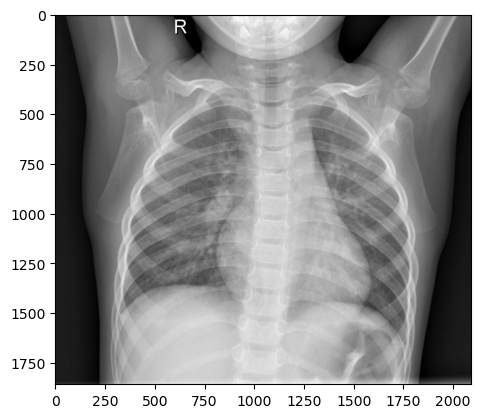

In [13]:
#First image of the multiclass normal set
sample_multi_train_nml_img1 = cv2.imread(os.path.join(multi_train_dir,'NORMAL',train_normal_files[0]))
plt.imshow(sample_multi_train_nml_img1)

In [14]:
sample_multi_train_nml_img1.shape

(1858, 2090, 3)

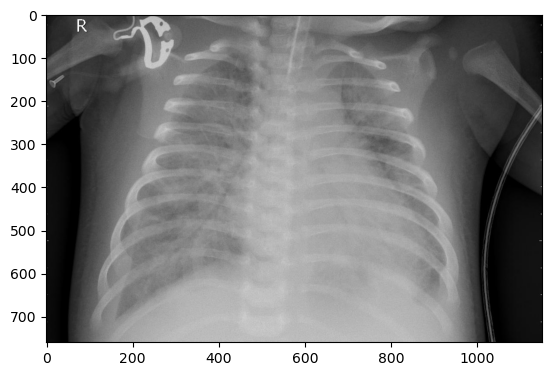

In [15]:
#First image of the multiclass bacterial pneumonia set
sample_multi_train_bac_pna_img1 = cv2.imread(os.path.join(multi_train_dir,'BAC_PNA',train_bac_pna_files[0]))
plt.imshow(sample_multi_train_bac_pna_img1)

In [16]:
sample_multi_train_bac_pna_img1.shape

(760, 1152, 3)

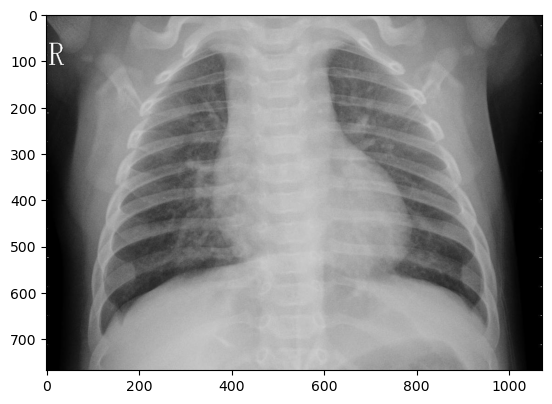

In [17]:
#First image of the multiclass viral pneumonia set
sample_multi_train_vir_pna_img1 = cv2.imread(os.path.join(multi_train_dir,'VIR_PNA',train_vir_pna_files[0]))
plt.imshow(sample_multi_train_vir_pna_img1)

In [18]:
sample_multi_train_vir_pna_img1.shape

(768, 1072, 3)

Notice, that the images can focus more on the lungs instead of the rest of the image. We can apply our function to do this.

### Focusing on the Lungs over Equipment - Multiclass

In [20]:
#Crop the images to focus on the lungs for train
focus_on_lungs('C:/Users/Ken/Documents/Python Scripts/data/pna_cxr_data/chest_xray/multiclass/train/NORMAL/')
focus_on_lungs('C:/Users/Ken/Documents/Python Scripts/data/pna_cxr_data/chest_xray/multiclass/train/BAC_PNA/')
focus_on_lungs('C:/Users/Ken/Documents/Python Scripts/data/pna_cxr_data/chest_xray/multiclass/train/VIR_PNA/')

In [21]:
#Check the new normal file number
train_normal_files = os.listdir(os.path.join(multi_train_dir,'NORMAL'))
print('train/NORMAL size: ',len(train_normal_files))

#Check the new pna file number
train_bac_pna_files = os.listdir(os.path.join(multi_train_dir,'BAC_PNA'))
print('train/BAC_PNA size: ',len(train_bac_pna_files))

#Check the new pna file number
train_vir_pna_files = os.listdir(os.path.join(multi_train_dir,'VIR_PNA'))
print('train/VIR_PNA size: ',len(train_vir_pna_files))

train/NORMAL size:  1349
train/BAC_PNA size:  2538
train/VIR_PNA size:  1345


This is a one-to-one conversion. Let's take a look at the prior two images shown to see how they look now.

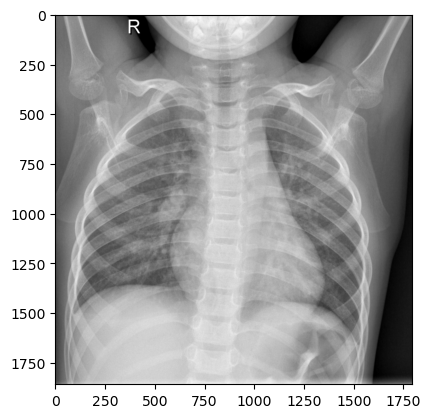

In [22]:
#First image of the multiclass normal set
sample_multi_train_nml_img1_cropped = cv2.imread(os.path.join(multi_train_dir,'NORMAL',train_normal_files[0]))
plt.imshow(sample_multi_train_nml_img1_cropped)

In [23]:
sample_multi_train_nml_img1_cropped.shape

(1858, 1793, 3)

(1858, 2090, 3) was the prior shape, so the width as been reduced to 1793.

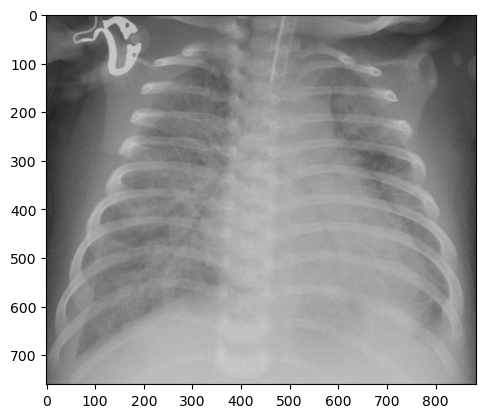

In [24]:
#First image of the multiclass bacterial pneumonia set
sample_multi_train_bac_pna_img1_cropped = cv2.imread(os.path.join(multi_train_dir,'BAC_PNA',train_bac_pna_files[0]))
plt.imshow(sample_multi_train_bac_pna_img1_cropped)

In [25]:
sample_multi_train_bac_pna_img1_cropped.shape

(760, 883, 3)

(760, 1152, 3) was the prior shape and from it we see the width decreased to 883.

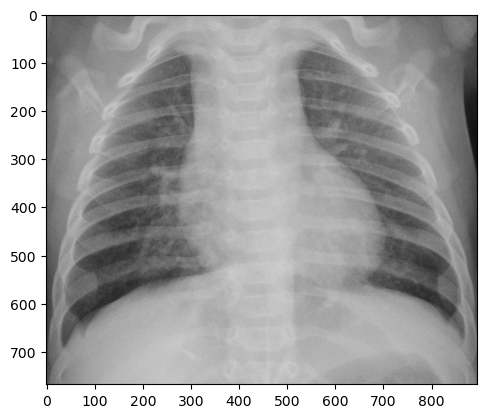

In [26]:
#First image of the multiclass viral pneumonia set
sample_multi_train_vir_pna_img1_cropped = cv2.imread(os.path.join(multi_train_dir,'VIR_PNA',train_vir_pna_files[0]))
plt.imshow(sample_multi_train_vir_pna_img1_cropped)

In [27]:
sample_multi_train_vir_pna_img1_cropped.shape

(768, 894, 3)

(768, 1072, 3) was the prior shape, so the width decreased to 894.

### Creating Image Datagenerators - Multiclass

We will create image datagenerators to add more versions of the images, i.e., image augmentation, to make the classifier more robust by increasing the amount of data seen. This is another way of dealing with class imbalance instead of upsampling or downsampling to be more generalized and not overfit. The methods of flipping, rotating, and zooming were choosen because they were non-destructive/do not distort the image. They will batch the images to be fed into different image classifiers.


In [154]:
#Setting parameters for flow_from_directory
pixels = 224 #The height and width will be set as the same, notice this will push the images to the same size.
batch_size = 32 #Each batch will have 32 images
class_mode = 'categorical' #This is multiclass so it will be set as such
color_mode = 'rgb' #This will give a 3 channel input
seed = 42 #This is for consistency between models

Notice now that the number of classes is no longer 2 but greater. Because of this, the class_mode is now "categorical" instead of "binary".

In [155]:
#Instantiating train and validation
#Flipping, rotating, and zooming allow for more variation
datagen_train = ImageDataGenerator(rescale = 1./255, #This is will convert the 0-255 to have values between 0 and 1 
                                  horizontal_flip=True, 
                                  vertical_flip=True,
                                  rotation_range=15,
                                  zoom_range=0.2,
                                  fill_mode='reflect', #When augmenting, there will be space that needs to be filled. This specifies how.
                                  validation_split=0.1) #The val will be given 10% which is approx the size of the test

#Normalizing the validation
validation_generator = ImageDataGenerator(rescale=1./255) #This is done the same so that when validating it will be in the same scale from 0 to 1

#The data will flow from the train directory that is separated between the 'training' and 'validation' subsets
#Most of the flow from directory 
#Generator for training data, shuffle set to True
train_generator = datagen_train.flow_from_directory(multi_train_dir,
                                                   target_size=(pixels, pixels),
                                                   color_mode= color_mode,
                                                   batch_size=batch_size,
                                                   class_mode= class_mode,
                                                   shuffle=True, subset='training', #shuffled to reduce overfitting
                                                   seed = seed)

#Generator for validation data, shuffle set to False
validation_generator = datagen_train.flow_from_directory(multi_train_dir,
                                                        target_size=(pixels, pixels),
                                                        color_mode=color_mode,
                                                        batch_size=batch_size,
                                                        class_mode=class_mode,
                                                        shuffle=False, subset='validation', #shuffling will not change anything in the validation since no training is done
                                                        seed = seed)

Found 4711 images belonging to 3 classes.
Found 521 images belonging to 3 classes.


In [156]:
#Normalizing the Test
datagen_test = ImageDataGenerator(rescale=1./255) #This is done the same so that the test will be in the same scale from 0 to 1

#Generator for test data
test_generator = datagen_test.flow_from_directory(multi_test_dir,
                                                   target_size=(pixels, pixels),
                                                   color_mode=color_mode,
                                                   batch_size=624, #Batch size should be the entire set
                                                   class_mode= class_mode,
                                                   seed = seed)
X_test,y_test =test_generator.next()

Found 624 images belonging to 3 classes.


In [67]:
train_step = train_generator.samples/train_generator.batch_size
print('# of steps for Train: ',round(train_step))
val_step = validation_generator.samples/validation_generator.batch_size
print('# of steps for Validation: ',round(val_step))

# of steps for Train:  147
# of steps for Validation:  16


Let's visualize the training's first batch.

In [34]:
batch = train_generator.next()

In [38]:
len(batch)

2

Each instance of the batch has an image and a label.

In [40]:
#Here are the images
batch[0]

array([[[[0.59990346, 0.59990346, 0.59990346],
         [0.5970925 , 0.5970925 , 0.5970925 ],
         [0.59317666, 0.59317666, 0.59317666],
         ...,
         [0.656131  , 0.656131  , 0.656131  ],
         [0.66071033, 0.66071033, 0.66071033],
         [0.6662706 , 0.6662706 , 0.6662706 ]],

        [[0.59377205, 0.59377205, 0.59377205],
         [0.6025061 , 0.6025061 , 0.6025061 ],
         [0.60276407, 0.60276407, 0.60276407],
         ...,
         [0.6580475 , 0.6580475 , 0.6580475 ],
         [0.6622422 , 0.6622422 , 0.6622422 ],
         [0.67180693, 0.67180693, 0.67180693]],

        [[0.5650986 , 0.5650986 , 0.5650986 ],
         [0.52787465, 0.52787465, 0.52787465],
         [0.49365592, 0.49365592, 0.49365592],
         ...,
         [0.6562744 , 0.6562744 , 0.6562744 ],
         [0.6587438 , 0.6587438 , 0.6587438 ],
         [0.66178817, 0.66178817, 0.66178817]],

        ...,

        [[0.16078432, 0.16078432, 0.16078432],
         [0.16086678, 0.16086678, 0.16086678]

In [35]:
#These are the images
batch[0].shape

(32, 224, 224, 3)

There are 32 images in this batch that are 224x224 and has 3 channels because it uses rgb.

In [42]:
#These are the labels
batch[1]

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

Each label is given as bac_pna, normal, or vir_pna where the "1" is placed respecitively in the list.

C:\Users\Ken\anaconda3\lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


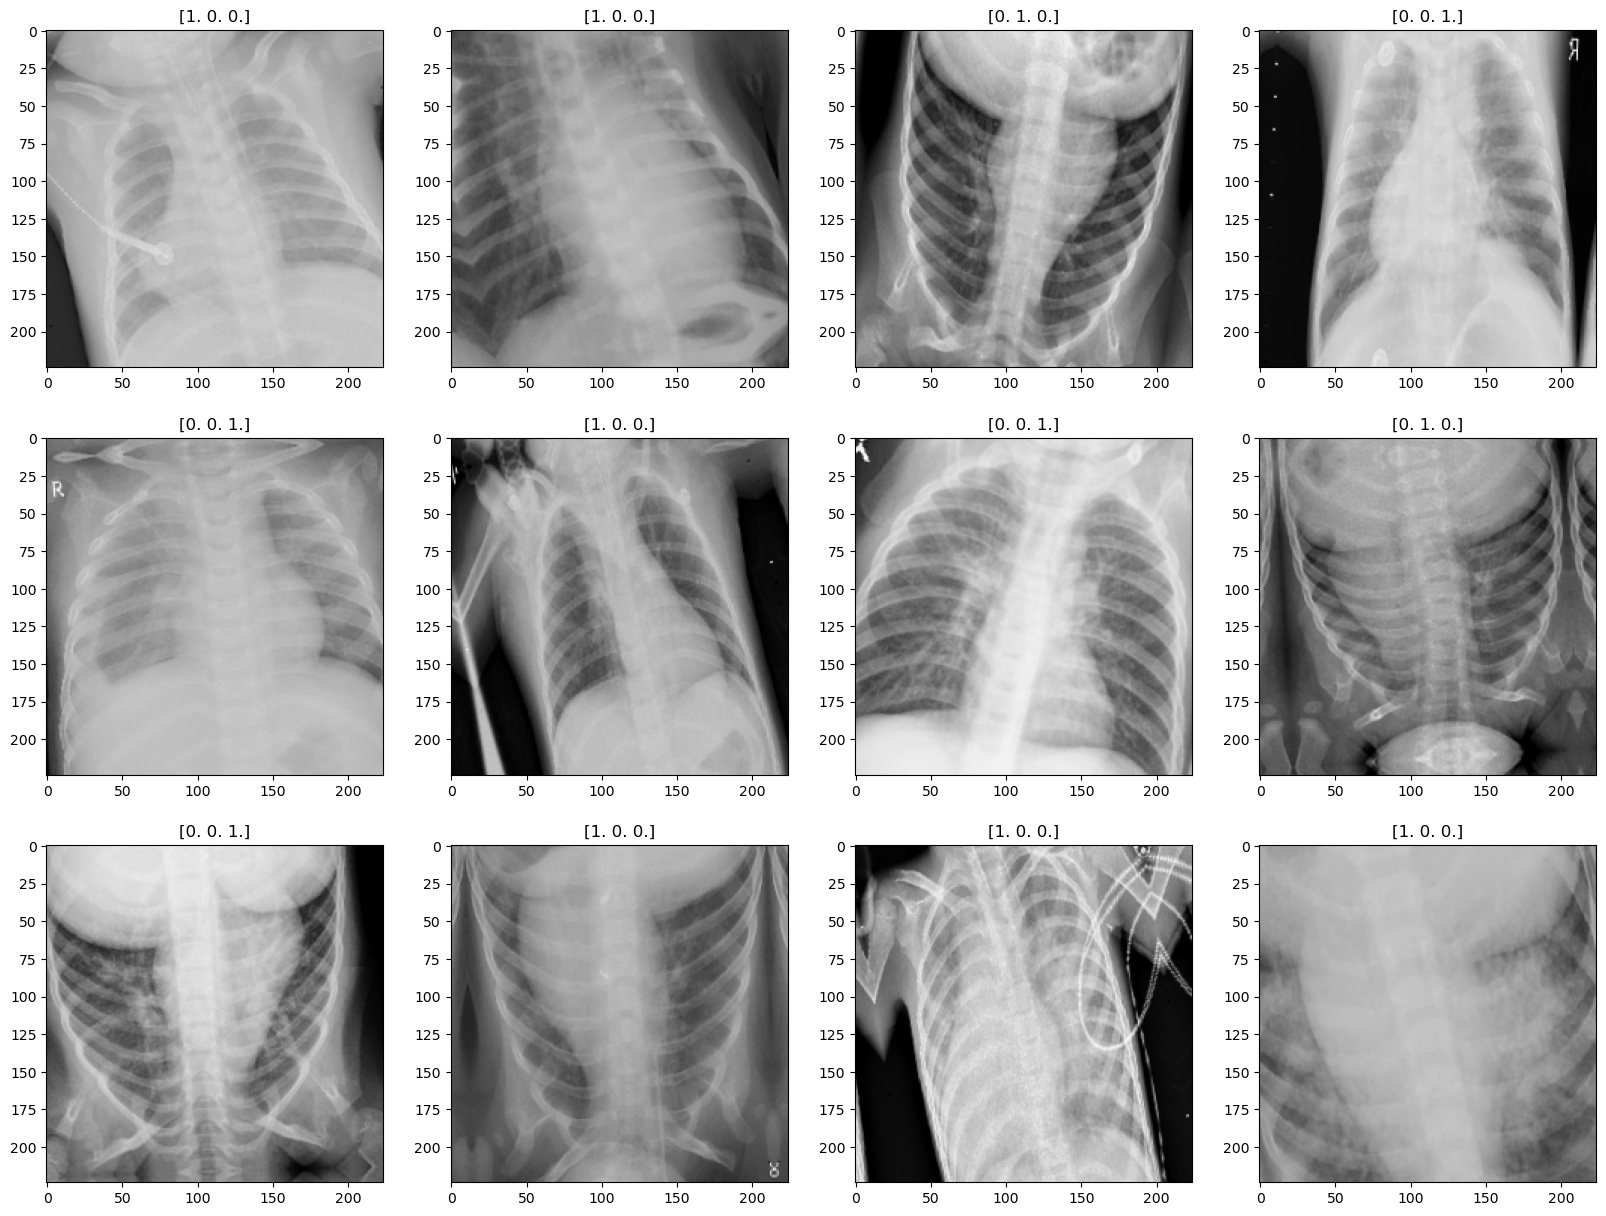

In [36]:
#Plot out 12 images with 3 rows and 4 columns
fig, ax = plt.subplots(nrows=3,ncols=4,figsize=(20,15))
#Turn it into 1D
ax = ax.flatten()
for idx, img in enumerate(batch[0][:12]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

The values are either 0 or 1 for among the three classes. Moreover, we can see that the images have been augmented by being flipped, zoomed, or rotated.

## Multiclass Models

With this project, I will be creating 3 multiclass models: 

(1) CNN model

(2) a ResNet-50 model with transfer learning with early stop

(3) a ResNet-50 model with transfer learning without early stop

For the models, there can be two ways for a physician to use it:

1. If the model predicts above a certain percentage like 97% that it is either normal, bacterial pneumonia,or viral pneumonia then the physician would not have to review that image. In this case, accuracy would be an important measure.

2. As long as the model will not misclassify a pneumonia image as normal, all the pneumonia cases can be reviewed by the physician. Why? It would be more detrimental to have a false negative, declaring any  pneumonia as normal than a false positive (the other way around). This means all the normal images will not have to be reviewed. For the evaluation metric, we can focus on recall since we want to be able to catch all the pneumonia cases. 

Other metric to evaluate can be AUC for the overall model's predictive power.

Note that specific model results will be recorded with wandb (weights and biases).

### Multiclass CNN Model


#### Building the Multiclass CNN Model


In [157]:
#the sequential model and the adding must be in the same cell
model = Sequential()
#first layer needs to have an input, see input_shape. 
model.add(Conv2D(16,(3,3),activation='relu',input_shape=(224,224,3))) 
#convolution here has 16 filters to extract relevant info
#3x3 pixels in size, and a stride of 1.
#relu makes all negative = 0, and positive values are directly proportional
model.add(MaxPooling2D())
#Takes the max value of a set region to condense information, by default this region size is 2x2, ie pool_size. 1/2 of width and height.

model.add(Conv2D(32,(3,3),1,activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16,(3,3),1,activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
#When we apply a convolutional layer the filters are the last channel. 

model.add(Dense(224,activation='relu'))

#softmax shows each of the prob adding up to 1
#predict one of each class, so 3 as the output.
model.add(Dense(3,activation='softmax'))

#optimizer is adam, loss is categoricalcrossentropy for multiclass classifier
model.compile('adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=['accuracy','AUC','Recall']) #metrics we are focused on

The difference here is the use of softmax as the final activation function instead of sigmoid from the binary classifier. In addition, the loss is no longer a BinaryCrossentropy but CategoricalCrossentropy.

In [158]:
#shows what happens at each step
model.summary() 
#before going to flatten layer 26*26*16 ->10816 for 1dim from many

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 111, 111, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 54, 54, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 52, 52, 16)        4624      
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 26, 26, 16)      

#### Finding the Multiclass weights

In [159]:
batch[1]

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

In [160]:
#Change the onehotencoding into ordinal encoding
batch_1_ordinal = np.argmax(batch[1],axis=1)
batch_1_ordinal

array([0, 0, 1, 2, 2, 0, 2, 1, 2, 0, 0, 0, 1, 2, 2, 1, 0, 0, 0, 0, 2, 1,
       1, 2, 0, 1, 2, 0, 1, 2, 2, 1], dtype=int64)

In [161]:
batch_1_ordinal_keys = list(np.unique(batch_1_ordinal))

In [162]:
batch_1_ordinal_keys

[0, 1, 2]

In [163]:
multiclass_class_weights = compute_class_weight(class_weight='balanced', classes=[0,1,2], y=batch_1_ordinal)

In [164]:
multiclass_class_weights=list(multiclass_class_weights)
multiclass_class_weights

[0.8888888888888888, 1.1851851851851851, 0.9696969696969697]

Create a dictionary for the class 0, 1, and 2 with these respective weights

In [165]:
multiclass_class_weights = {batch_1_ordinal_keys[i]: multiclass_class_weights[i] for i in range(len(batch_1_ordinal_keys))}
multiclass_class_weights

{0: 0.8888888888888888, 1: 1.1851851851851851, 2: 0.9696969696969697}

#### Training the Multiclass CNN Model


In [166]:
#Set the number of epochs
epochs = 10

In [167]:
#Initalize a new run (with weights and biases specifying a team name) and returns a run object,
#It creates a local directory where all logs and files are saved
#Pass in config={:,:,:} for what will be the hyperparameters,dataset name, model type,ind var to compare different runs 
wandb.init(project="Multiclass-CNN", entity="team-lkc",
          config={
              "epochs":epochs,
              "batch size":batch_size,
              "class mode":class_mode,
              "height and width in pixels":pixels,
              "number of channels":color_mode,
              "class weight":multiclass_class_weights,
              "seed":seed
          })

In [168]:
#an epoch is 1 run over entire training set of data
hist = model.fit(train_generator,
                 epochs=epochs,
                 validation_data=validation_generator,
                 class_weight=multiclass_class_weights, #class_weight needs to be added here not the compile
                 callbacks=[WandbCallback()])

Epoch 1/10
148/148 [==============================] - ETA: 0s - loss: 0.9925 - accuracy: 0.5188 - auc: 0.6866 - recall: 0.1579

INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230317_223221-etyhca1h\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230317_223221-etyhca1h\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Ken\Documents\Python Scripts\wandb\run-20230317_223221-etyhca1h\files\model-best)... Done. 0.2s


148/148 [==============================] - 332s 2s/step - loss: 0.9925 - accuracy: 0.5188 - auc: 0.6866 - recall: 0.1579 - val_loss: 0.8002 - val_accuracy: 0.6699 - val_auc: 0.8292 - val_recall: 0.5240
Epoch 2/10
148/148 [==============================] - ETA: 0s - loss: 0.7666 - accuracy: 0.6512 - auc: 0.8280 - recall: 0.5470

INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230317_223221-etyhca1h\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230317_223221-etyhca1h\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Ken\Documents\Python Scripts\wandb\run-20230317_223221-etyhca1h\files\model-best)... Done. 0.2s


148/148 [==============================] - 302s 2s/step - loss: 0.7666 - accuracy: 0.6512 - auc: 0.8280 - recall: 0.5470 - val_loss: 0.7299 - val_accuracy: 0.7063 - val_auc: 0.8621 - val_recall: 0.5893
Epoch 3/10
148/148 [==============================] - ETA: 0s - loss: 0.7088 - accuracy: 0.6839 - auc: 0.8505 - recall: 0.5952

INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230317_223221-etyhca1h\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230317_223221-etyhca1h\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Ken\Documents\Python Scripts\wandb\run-20230317_223221-etyhca1h\files\model-best)... Done. 0.3s


148/148 [==============================] - 306s 2s/step - loss: 0.7088 - accuracy: 0.6839 - auc: 0.8505 - recall: 0.5952 - val_loss: 0.6689 - val_accuracy: 0.7486 - val_auc: 0.8889 - val_recall: 0.6718
Epoch 4/10
148/148 [==============================] - 297s 2s/step - loss: 0.6893 - accuracy: 0.6865 - auc: 0.8583 - recall: 0.6122 - val_loss: 0.7520 - val_accuracy: 0.6372 - val_auc: 0.8501 - val_recall: 0.5643
Epoch 5/10
148/148 [==============================] - ETA: 0s - loss: 0.6470 - accuracy: 0.7007 - auc: 0.8733 - recall: 0.6394

INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230317_223221-etyhca1h\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230317_223221-etyhca1h\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Ken\Documents\Python Scripts\wandb\run-20230317_223221-etyhca1h\files\model-best)... Done. 0.2s


148/148 [==============================] - 359s 2s/step - loss: 0.6470 - accuracy: 0.7007 - auc: 0.8733 - recall: 0.6394 - val_loss: 0.6517 - val_accuracy: 0.7754 - val_auc: 0.9025 - val_recall: 0.6718
Epoch 6/10
148/148 [==============================] - ETA: 0s - loss: 0.6442 - accuracy: 0.7071 - auc: 0.8743 - recall: 0.6512

INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230317_223221-etyhca1h\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230317_223221-etyhca1h\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Ken\Documents\Python Scripts\wandb\run-20230317_223221-etyhca1h\files\model-best)... Done. 0.1s


148/148 [==============================] - 298s 2s/step - loss: 0.6442 - accuracy: 0.7071 - auc: 0.8743 - recall: 0.6512 - val_loss: 0.5813 - val_accuracy: 0.7658 - val_auc: 0.9117 - val_recall: 0.7217
Epoch 7/10
148/148 [==============================] - 299s 2s/step - loss: 0.6375 - accuracy: 0.7109 - auc: 0.8763 - recall: 0.6549 - val_loss: 0.5926 - val_accuracy: 0.7812 - val_auc: 0.9108 - val_recall: 0.7236
Epoch 8/10
148/148 [==============================] - 302s 2s/step - loss: 0.6046 - accuracy: 0.7236 - auc: 0.8878 - recall: 0.6761 - val_loss: 0.6233 - val_accuracy: 0.7774 - val_auc: 0.9049 - val_recall: 0.7217
Epoch 9/10
148/148 [==============================] - 173s 1s/step - loss: 0.6019 - accuracy: 0.7302 - auc: 0.8897 - recall: 0.6827 - val_loss: 0.5843 - val_accuracy: 0.7850 - val_auc: 0.9180 - val_recall: 0.7370
Epoch 10/10
148/148 [==============================] - ETA: 0s - loss: 0.6027 - accuracy: 0.7264 - auc: 0.8883 - recall: 0.6801

INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230317_223221-etyhca1h\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230317_223221-etyhca1h\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Ken\Documents\Python Scripts\wandb\run-20230317_223221-etyhca1h\files\model-best)... Done. 0.1s


148/148 [==============================] - 141s 954ms/step - loss: 0.6027 - accuracy: 0.7264 - auc: 0.8883 - recall: 0.6801 - val_loss: 0.5727 - val_accuracy: 0.7774 - val_auc: 0.9138 - val_recall: 0.7217


#### Evaluating Multiclass CNN Model


In [169]:
score = model.evaluate(X_test,y_test,verbose=1)
wandb.log({'Test Loss': score[0], 'Test Accuracy': score[1]})

20/20 [==============================] - 2s 73ms/step - loss: 0.6534 - accuracy: 0.7917 - auc: 0.8955 - recall: 0.7179


Recall that the baseline for this imbalanced set is 49% accuracy based on the majority class of bacterial pneumonia.

In [170]:
#Get predict probas
predict_probas = model.predict(X_test)
#Changing the array into a onehotencoding format selecting the class with the highest probability
predictions=np.zeros_like(predict_probas)
predictions[np.arange(len(predict_probas)),np.argmax(predict_probas,axis=1)]=1
print(predictions)

20/20 [==============================] - 2s 74ms/step
[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [171]:
#Change the onehotencoding into ordinal encoding
predicted_ordinal_labels=np.argmax(predictions,axis=1)
true_ordinal_labels=np.argmax(y_test,axis=1)

In [172]:
#A 3x3 matrix of the results
conf_mat = confusion_matrix(true_ordinal_labels,predicted_ordinal_labels)
cf_df = pd.DataFrame(conf_mat,columns=["Predicted Bacterial PNA","Predicted Normal","Predicted Viral Pneumonia"],
                     index=["True Bacterial PNA","True Normal","True Viral PNA"])
cf_df

Predicted Bacterial PNA  Predicted Normal  \
True Bacterial PNA                      176                45   
True Normal                               8               195   
True Viral PNA                           15                10   

                    Predicted Viral Pneumonia  
True Bacterial PNA                         21  
True Normal                                31  
True Viral PNA                            123

In [173]:
print(classification_report(true_ordinal_labels,predicted_ordinal_labels))

              precision    recall  f1-score   support

           0       0.88      0.73      0.80       242
           1       0.78      0.83      0.81       234
           2       0.70      0.83      0.76       148

    accuracy                           0.79       624
   macro avg       0.79      0.80      0.79       624
weighted avg       0.80      0.79      0.79       624



The model has a test accuracy of 0.7917 and a test loss of 0.6534. The test loss is quite high. It also has an AUC is 0.8955 with a recall is 0.7179. The recall shown in the classification report shows that most of the recall was from viral pna at 0.83 and bacterial pna at 0.73. Ideally this recall should be at 1.0 to reduce more of the workload since the test accuracy is not sufficient.

## Multiclass ResNet-50 Transfer Learning with Early Stop

#### Building the Multiclass ResNet-50 - TL 

In [174]:
def set_random_seed(seed):
    '''Random seeds for reproducability'''
    random.seed(seed)
    tf.random.set_seed(seed)

In [175]:
#Reduce any larger sized image -> 224 px
#reshape the images to 224 in train and validation
res_model = ResNet50V2(weights='imagenet',
                      include_top=False,
                      input_shape=(224,224,3))

In [176]:
#Freeze all layers in the base model
for layer in res_model.layers:
    layer.trainable = False

In [177]:
#Set the seed
seed = 42
set_random_seed(seed)

In [178]:
x = res_model.output
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
#one of the three classes
output = Dense(3,activation='softmax')(x)

trsf_model = Model(inputs=res_model.input,
     outputs=output)

In [179]:
trsf_model.compile(optimizer='Adam',
                  loss=tf.losses.CategoricalCrossentropy(),
                  metrics=['accuracy','AUC','Recall'])

In [180]:
trsf_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

                                                                                                  
 conv2_block3_preact_relu (Acti  (None, 56, 56, 256)  0          ['conv2_block3_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 56, 56, 64)   16384       ['conv2_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_blo

                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 28, 28, 128)  147456      ['conv3_block2_2_pad[0][0]']     
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block2_2_relu[0][0]']    
          

 vation)                                                                                          
                                                                                                  
 conv4_block1_1_conv (Conv2D)   (None, 14, 14, 256)  131072      ['conv4_block1_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_1_bn[0][0]']      
 n)                                                                                               
          

 conv4_block3_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block3_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block3_out (Add)         (None, 14, 14, 1024  0           ['conv4_block2_out[0][0]',       
          

                                                                 ]                                
                                                                                                  
 conv4_block6_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block6_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block6_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block6_2_pad (ZeroPaddin  (None, 16, 16, 256)  0          ['conv4_block6_1_relu[0][0]']    
 g2D)                                                                                             
          

                                                                                                  
 conv5_block2_2_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_out (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_conv[0][0]']    
                                                                                                  
 conv5_block3_preact_bn (BatchN  (None, 7, 7, 2048)  8192        ['conv5_block2_out[0][0]']       
 ormalizat

#### Training the Multiclass ResNet-50 - TL + Early Stop


In [181]:
#early stop when no longer improving on validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=2, #wait for 2 epochs to stop if no improvement
                           mode='min',
                           verbose=1)

In [182]:
epochs = 10
early_stop_binary = True

In [183]:
wandb.init(project="Multiclass-ResNet50-TL-EarlyStop", entity="team-lkc",
          config={
              "epochs":epochs,
              "batch size":batch_size,
              "class mode":class_mode,
              "height and width in pixels":pixels,
              "number of channels":color_mode,
              "early stop implemented":early_stop_binary,
              "seed":seed
          })

In [184]:
#No weights here because the weights were pretrained with the transfer learning
hist = trsf_model.fit(train_generator,
                     epochs=epochs,
                     validation_data=validation_generator,
                     callbacks=[WandbCallback(),early_stop]) #early_stop in the callback will stop training if needed

Epoch 1/10
148/148 [==============================] - ETA: 0s - loss: 0.8872 - accuracy: 0.6782 - auc: 0.8526 - recall: 0.6268

INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230317_234607-qsrzrr3q\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230317_234607-qsrzrr3q\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Ken\Documents\Python Scripts\wandb\run-20230317_234607-qsrzrr3q\files\model-best)... Done. 0.4s


148/148 [==============================] - 252s 2s/step - loss: 0.8872 - accuracy: 0.6782 - auc: 0.8526 - recall: 0.6268 - val_loss: 0.6234 - val_accuracy: 0.6910 - val_auc: 0.8857 - val_recall: 0.6296
Epoch 2/10
148/148 [==============================] - ETA: 0s - loss: 0.6060 - accuracy: 0.7105 - auc: 0.8920 - recall: 0.6633

INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230317_234607-qsrzrr3q\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230317_234607-qsrzrr3q\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Ken\Documents\Python Scripts\wandb\run-20230317_234607-qsrzrr3q\files\model-best)... Done. 0.4s


148/148 [==============================] - 398s 3s/step - loss: 0.6060 - accuracy: 0.7105 - auc: 0.8920 - recall: 0.6633 - val_loss: 0.5822 - val_accuracy: 0.7428 - val_auc: 0.9104 - val_recall: 0.6564
Epoch 3/10
148/148 [==============================] - ETA: 0s - loss: 0.5890 - accuracy: 0.7311 - auc: 0.8994 - recall: 0.6676

INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230317_234607-qsrzrr3q\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230317_234607-qsrzrr3q\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Ken\Documents\Python Scripts\wandb\run-20230317_234607-qsrzrr3q\files\model-best)... Done. 0.3s


148/148 [==============================] - 377s 3s/step - loss: 0.5890 - accuracy: 0.7311 - auc: 0.8994 - recall: 0.6676 - val_loss: 0.5720 - val_accuracy: 0.7543 - val_auc: 0.9165 - val_recall: 0.6660
Epoch 4/10
148/148 [==============================] - 374s 3s/step - loss: 0.5804 - accuracy: 0.7302 - auc: 0.9031 - recall: 0.6731 - val_loss: 0.6136 - val_accuracy: 0.7198 - val_auc: 0.9029 - val_recall: 0.6737
Epoch 5/10
148/148 [==============================] - ETA: 0s - loss: 0.5637 - accuracy: 0.7432 - auc: 0.9083 - recall: 0.6672

INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230317_234607-qsrzrr3q\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230317_234607-qsrzrr3q\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Ken\Documents\Python Scripts\wandb\run-20230317_234607-qsrzrr3q\files\model-best)... Done. 0.3s


148/148 [==============================] - 385s 3s/step - loss: 0.5637 - accuracy: 0.7432 - auc: 0.9083 - recall: 0.6672 - val_loss: 0.5157 - val_accuracy: 0.7601 - val_auc: 0.9239 - val_recall: 0.6910
Epoch 6/10
148/148 [==============================] - 376s 3s/step - loss: 0.5449 - accuracy: 0.7463 - auc: 0.9130 - recall: 0.6784 - val_loss: 0.5192 - val_accuracy: 0.7889 - val_auc: 0.9351 - val_recall: 0.6545
Epoch 7/10
148/148 [==============================] - ETA: 0s - loss: 0.5337 - accuracy: 0.7633 - auc: 0.9174 - recall: 0.6703

INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230317_234607-qsrzrr3q\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230317_234607-qsrzrr3q\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Ken\Documents\Python Scripts\wandb\run-20230317_234607-qsrzrr3q\files\model-best)... Done. 0.7s


148/148 [==============================] - 445s 3s/step - loss: 0.5337 - accuracy: 0.7633 - auc: 0.9174 - recall: 0.6703 - val_loss: 0.4978 - val_accuracy: 0.7869 - val_auc: 0.9318 - val_recall: 0.7063
Epoch 8/10
148/148 [==============================] - 801s 5s/step - loss: 0.5186 - accuracy: 0.7567 - auc: 0.9201 - recall: 0.6816 - val_loss: 0.5127 - val_accuracy: 0.7793 - val_auc: 0.9265 - val_recall: 0.6948
Epoch 9/10
148/148 [==============================] - ETA: 0s - loss: 0.5126 - accuracy: 0.7722 - auc: 0.9230 - recall: 0.7069

INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230317_234607-qsrzrr3q\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230317_234607-qsrzrr3q\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Ken\Documents\Python Scripts\wandb\run-20230317_234607-qsrzrr3q\files\model-best)... Done. 0.7s


148/148 [==============================] - 828s 6s/step - loss: 0.5126 - accuracy: 0.7722 - auc: 0.9230 - recall: 0.7069 - val_loss: 0.4355 - val_accuracy: 0.8196 - val_auc: 0.9501 - val_recall: 0.7217
Epoch 10/10
148/148 [==============================] - 775s 5s/step - loss: 0.4971 - accuracy: 0.7625 - auc: 0.9257 - recall: 0.7251 - val_loss: 0.4369 - val_accuracy: 0.8311 - val_auc: 0.9483 - val_recall: 0.8061


#### Evaluating the Multiclass ResNet-50 - TL + Early Stop

In [185]:
score = trsf_model.evaluate(X_test,y_test,verbose=1)
wandb.log({'Test Loss': score[0], 'Test Accuracy': score[1]})

20/20 [==============================] - 89s 4s/step - loss: 0.6011 - accuracy: 0.7772 - auc: 0.9145 - recall: 0.7532


In [186]:
#Get predict probas
predict_probas = trsf_model.predict(X_test)

20/20 [==============================] - 88s 4s/step


In [187]:
#What is returned...
predict_probas

array([[7.9480442e-04, 9.9787414e-01, 1.3310520e-03],
       [2.6665774e-01, 2.2809529e-01, 5.0524700e-01],
       [8.0059135e-01, 1.3407228e-04, 1.9927458e-01],
       ...,
       [2.8338527e-02, 9.2117447e-01, 5.0487004e-02],
       [4.0749094e-01, 7.1126610e-02, 5.2138245e-01],
       [5.7740760e-01, 8.3088344e-03, 4.1428351e-01]], dtype=float32)

In [188]:
#Changing the array into a onehotencoding format selecting the class with the highest probability
predictions=np.zeros_like(predict_probas)
predictions[np.arange(len(predict_probas)),np.argmax(predict_probas,axis=1)]=1
print(predictions)

[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 ...
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]


In [189]:
#Change the onehotencoding into ordinal encoding
predicted_ordinal_labels=np.argmax(predictions,axis=1)
true_ordinal_labels=np.argmax(y_test,axis=1)

In [190]:
#A 3x3 matrix of the results
conf_mat = confusion_matrix(true_ordinal_labels,predicted_ordinal_labels)
cf_df = pd.DataFrame(conf_mat,columns=["Predicted Bacterial PNA","Predicted Normal","Predicted Viral Pneumonia"],
                     index=["True Bacterial PNA","True Normal","True Viral PNA"])
cf_df

Predicted Bacterial PNA  Predicted Normal  \
True Bacterial PNA                      228                 9   
True Normal                              17               179   
True Viral PNA                           68                 2   

                    Predicted Viral Pneumonia  
True Bacterial PNA                          5  
True Normal                                38  
True Viral PNA                             78

In [191]:
print(classification_report(true_ordinal_labels,predicted_ordinal_labels))

              precision    recall  f1-score   support

           0       0.73      0.94      0.82       242
           1       0.94      0.76      0.84       234
           2       0.64      0.53      0.58       148

    accuracy                           0.78       624
   macro avg       0.77      0.74      0.75       624
weighted avg       0.79      0.78      0.77       624



The test accuracy of the model was 0.7772 with a test loss of 0.6011. This model is not that great despite having a high AUC of 0.9145. The recall was 0.7532, but in the classification report we see that the recall for the bacterial pneumonia was 0.94 while the recall for the viral pneumonia was 0.53 meaning that this model would fail to recall these cases which is not sufficient in our situation.

## Multiclass ResNet-50 Transfer Learning without Early Stop

#### Training the Multiclass ResNet-50 - TL + No Early Stop

In [192]:
epochs = 10
early_stop_binary = False

In [193]:
wandb.init(project="Multiclass-ResNet50-TL-NoEarlyStop", entity="team-lkc",
          config={
              "epochs":epochs,
              "batch size":batch_size,
              "class mode":class_mode,
              "height and width in pixels":pixels,
              "number of channels":color_mode,
              "early stop implemented":early_stop_binary,
              "seed":seed
          })

In [194]:
#No weights here because the weights were pretrained with the transfer learning
hist = trsf_model.fit(train_generator,
                     epochs=epochs,
                     validation_data=validation_generator,
                     callbacks=[WandbCallback()]) #no early_stop in the callback 

Epoch 1/10
148/148 [==============================] - ETA: 0s - loss: 0.4945 - accuracy: 0.7733 - auc: 0.9279 - recall: 0.7521

INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230318_012816-gkieaqrq\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230318_012816-gkieaqrq\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Ken\Documents\Python Scripts\wandb\run-20230318_012816-gkieaqrq\files\model-best)... Done. 0.5s


148/148 [==============================] - 400s 3s/step - loss: 0.4945 - accuracy: 0.7733 - auc: 0.9279 - recall: 0.7521 - val_loss: 0.4727 - val_accuracy: 0.8081 - val_auc: 0.9392 - val_recall: 0.7946
Epoch 2/10
148/148 [==============================] - ETA: 0s - loss: 0.4891 - accuracy: 0.7816 - auc: 0.9297 - recall: 0.7646

INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230318_012816-gkieaqrq\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230318_012816-gkieaqrq\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Ken\Documents\Python Scripts\wandb\run-20230318_012816-gkieaqrq\files\model-best)... Done. 0.4s


148/148 [==============================] - 387s 3s/step - loss: 0.4891 - accuracy: 0.7816 - auc: 0.9297 - recall: 0.7646 - val_loss: 0.4458 - val_accuracy: 0.7965 - val_auc: 0.9424 - val_recall: 0.7812
Epoch 3/10
148/148 [==============================] - ETA: 0s - loss: 0.4805 - accuracy: 0.7831 - auc: 0.9331 - recall: 0.7678

INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230318_012816-gkieaqrq\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230318_012816-gkieaqrq\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Ken\Documents\Python Scripts\wandb\run-20230318_012816-gkieaqrq\files\model-best)... Done. 0.3s


148/148 [==============================] - 389s 3s/step - loss: 0.4805 - accuracy: 0.7831 - auc: 0.9331 - recall: 0.7678 - val_loss: 0.4288 - val_accuracy: 0.8177 - val_auc: 0.9530 - val_recall: 0.8061
Epoch 4/10
148/148 [==============================] - 376s 3s/step - loss: 0.4845 - accuracy: 0.7833 - auc: 0.9313 - recall: 0.7661 - val_loss: 0.4514 - val_accuracy: 0.8369 - val_auc: 0.9475 - val_recall: 0.8196
Epoch 5/10
148/148 [==============================] - ETA: 0s - loss: 0.4770 - accuracy: 0.7941 - auc: 0.9343 - recall: 0.7809

INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230318_012816-gkieaqrq\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230318_012816-gkieaqrq\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Ken\Documents\Python Scripts\wandb\run-20230318_012816-gkieaqrq\files\model-best)... Done. 0.3s


148/148 [==============================] - 389s 3s/step - loss: 0.4770 - accuracy: 0.7941 - auc: 0.9343 - recall: 0.7809 - val_loss: 0.4044 - val_accuracy: 0.8196 - val_auc: 0.9541 - val_recall: 0.7985
Epoch 6/10
148/148 [==============================] - 366s 2s/step - loss: 0.4728 - accuracy: 0.7888 - auc: 0.9340 - recall: 0.7714 - val_loss: 0.4045 - val_accuracy: 0.8484 - val_auc: 0.9651 - val_recall: 0.8349
Epoch 7/10
148/148 [==============================] - 368s 2s/step - loss: 0.4636 - accuracy: 0.7952 - auc: 0.9379 - recall: 0.7818 - val_loss: 0.4116 - val_accuracy: 0.8157 - val_auc: 0.9532 - val_recall: 0.8061
Epoch 8/10
148/148 [==============================] - 371s 3s/step - loss: 0.4613 - accuracy: 0.7975 - auc: 0.9381 - recall: 0.7852 - val_loss: 0.4307 - val_accuracy: 0.8234 - val_auc: 0.9473 - val_recall: 0.8119
Epoch 9/10
148/148 [==============================] - 368s 2s/step - loss: 0.4550 - accuracy: 0.8024 - auc: 0.9410 - recall: 0.7941 - val_loss: 0.4059 - val_ac

INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230318_012816-gkieaqrq\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Ken\Documents\Python Scripts\wandb\run-20230318_012816-gkieaqrq\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Ken\Documents\Python Scripts\wandb\run-20230318_012816-gkieaqrq\files\model-best)... Done. 0.3s


148/148 [==============================] - 381s 3s/step - loss: 0.4551 - accuracy: 0.8026 - auc: 0.9398 - recall: 0.7909 - val_loss: 0.3692 - val_accuracy: 0.8714 - val_auc: 0.9653 - val_recall: 0.8522


#### Evaluating the Multiclass ResNet-50 - TL + No Early Stop

In [195]:
score = trsf_model.evaluate(X_test,y_test,verbose=1)
wandb.log({'Test Loss': score[0], 'Test Accuracy': score[1]})

20/20 [==============================] - 41s 2s/step - loss: 0.4471 - accuracy: 0.8494 - auc: 0.9477 - recall: 0.8446


Recall that the baseline for this imbalanced set is 49% accuracy based on the majority class of bacterial pneumonia.

In [196]:
#Get predict probas
predict_probas = model.predict(X_test)
#Changing the array into a onehotencoding format selecting the class with the highest probability
predictions=np.zeros_like(predict_probas)
predictions[np.arange(len(predict_probas)),np.argmax(predict_probas,axis=1)]=1
print(predictions)

20/20 [==============================] - 2s 115ms/step
[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [197]:
#Change the onehotencoding into ordinal encoding
predicted_ordinal_labels=np.argmax(predictions,axis=1)
true_ordinal_labels=np.argmax(y_test,axis=1)

In [198]:
#A 3x3 matrix of the results
conf_mat = confusion_matrix(true_ordinal_labels,predicted_ordinal_labels)
cf_df = pd.DataFrame(conf_mat,columns=["Predicted Bacterial PNA","Predicted Normal","Predicted Viral Pneumonia"],
                     index=["True Bacterial PNA","True Normal","True Viral PNA"])
cf_df

Predicted Bacterial PNA  Predicted Normal  \
True Bacterial PNA                      176                45   
True Normal                               8               195   
True Viral PNA                           15                10   

                    Predicted Viral Pneumonia  
True Bacterial PNA                         21  
True Normal                                31  
True Viral PNA                            123

In [199]:
print(classification_report(true_ordinal_labels,predicted_ordinal_labels))

              precision    recall  f1-score   support

           0       0.88      0.73      0.80       242
           1       0.78      0.83      0.81       234
           2       0.70      0.83      0.76       148

    accuracy                           0.79       624
   macro avg       0.79      0.80      0.79       624
weighted avg       0.80      0.79      0.79       624



The model has a test accuracy of 0.8494 and a test loss of 0.4471. The AUC is 0.9477 and the recall is 0.8446. The recall shown in the classification report shows that most of the recall was from viral pna, but it was at 0.83 and the bacterial pna was only 0.73. The recall should ideally be 1.0 to be practical for a physician beyond relying on just the accuracy which is still low.

## Evaluating and Selecting a Multiclass Model


To recap:

Multiclass CNN Model: 

- loss: 0.6534 - accuracy: 0.7917 - auc: 0.8955 - recall: 0.7179

Multiclass ResNet-50 TF + Early Stop: 

- loss: 0.6011 - accuracy: 0.7772 - auc: 0.9145 - recall: 0.7532

Multiclass ResNet-50 TF no Early Stop: 

- loss: 0.4471 - accuracy: 0.8494 - auc: 0.9477 - recall: 0.8446

Discussion:

The best model for accuracy is Binary ResNet-50 TF without the early stop at 84.94%. The best model for recall is the same model at 84.46%. Because of this the model to be deployed will be this.

### Saving the Best Multiclass Model

The model will be saved as an h5 file that will be used in a streamlit application from another script.

In [200]:
#Saving the model.
#Serializing the model to store in disk. Like zipping a dataset.
trsf_model.save(os.path.join('models','Multiclass_RN50_TF_NO_ES_031823.h5')) #Saved the date MM/DD/YY of last model

### Loading the Best Multiclass Model

In [ ]:
#How to load the model with a given path
best_multiclass_model = load_model(os.path.join('models','Multiclass_RN50_TF_ES_031623.h5')) 